# **HW 1: Credit Card Churn Prediction**
<hr>

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Athimet Aiewcharoen 63340500068
<hr>

## **Function and Import Necessary Libraries**

In [1341]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder , RobustScaler

# ignore warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RepeatedKFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy.stats import sem

from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

In [1342]:
def diagnostic_plots(df, variable:str):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].plot.hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()  

In [1343]:
def checkCorrFF(df):
    plt.figure(figsize=(20,10))
    cor = df.corr()
    # mask = np.zeros_like(cor, dtype=np.bool)
    # mask[np.triu_indices_from(mask)] = True
    sns.heatmap(cor, annot=True, cmap='inferno')
    plt.show()

In [1344]:
def checkCorrFT(df, target):
    sns.pairplot(df, hue = target)

In [1345]:
def checkOutput(df, col:str, colTarget:str, output:str):
    checkdf = df.loc[df[col] == colTarget]
    return checkdf[output].value_counts()

In [1346]:
def IQRdrop(df, col:str):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df.loc[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
    return df

In [1347]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats,scores):
	# prepare the cross-validation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
	# create model
	model = LogisticRegression()
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=scores, cv=cv, n_jobs=-1)
	return scores

## **Data Exploration**

There are a total of 23 features in this dataset which are:

|Feature Name|Description|Data Type|
|-|-|-|
|<font color='green'>CLIENTNUM</font>|Unique identifier for the customer holding the account|
|<font color='green'>Attrition_Flag</font>|Internal event (customer activity) variable (Existing = 1, Attrited = 0)|<font color='red'>Categorical</font> [Output]|
|<font color='green'>Customer_Age</font>|Customer's Age in Years|<font color='red'>Numerical</font>|
|<font color='green'>Gender</font>|(M = Male, F = Female)|<font color='red'>Categorical</font>|
|<font color='green'>Dependent_Count</font>|Number of dependents|<font color='red'>Numerical</font>|
|<font color='green'>Education_Level</font>|Educational Qualification of the account holder (Uneducated, High School, College, Graduate, Post-Graduate, Doctorate, Unknown)|<font color='red'>Categorical</font>|
|<font color='green'>Marital_Status</font>|(Married, Single, Divorced, Unknown)|<font color='red'>Categorical</font>|
|<font color='green'>Income_Category</font>|Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, >$120K)|<font color='red'>Categorical</font>|
|<font color='green'>Card_Category</font>|Type of Card (Blue, Silver, Gold, Platinum)</font>|<font color='red'>Categorical</font>|
|<font color='green'>Months_on_book</font>|Period of relationship with bank|<font color='red'>Numerical</font>|
|<font color='green'>Total_Relationship_Count</font>|Total no. of products held by the customer|<font color='red'>Numerical</font>|
|<font color='green'>Months_Inactive_12_mon</font>|No. of months inactive in the last 12 months|<font color='red'>Numerical</font>|
|<font color='green'>Contacts_Count_12_mon</font>|No. of Contacts in the last 12 months|<font color='red'>Numerical</font>|
|<font color='green'>Credit_Limit</font>|Credit Limit on the Credit Card|<font color='red'>Numerical</font>|
|<font color='green'>Total_Revolving_Bal</font>|Total Revolving Balance on the Credit Card|<font color='red'>Numerical</font>|
|<font color='green'>Avg_Open_To_Buy</font>|Open to Buy Credit Line (Average of last 12 months)|<font color='red'>Numerical</font>|
|<font color='green'>Total_Amt_Chng_Q4_Q1</font>|Change in Transaction Amount (Q4 over Q1)|<font color='red'>Numerical</font>|
|<font color='green'>Total_Trans_Amt</font>|Total Transaction Amount (Last 12 months)|<font color='red'>Numerical</font>|
|<font color='green'>Total_Trans_Ct</font>|Total Transaction Count (Last 12 months)|<font color='red'>Numerical</font>|
|<font color='green'>Total_Ct_Chng_Q4_Q1</font>|Change in Transaction Count (Q4 over Q1)|<font color='red'>Numerical</font>|
|<font color='green'>Avg_Utilization_Ratio</font>|Average Card Utilization Ratio|<font color='red'>Numerical</font>|
|<font color='green'>Naive_Bayes_Classifier...</font>|Naive Bayes||
|<font color='green'>Naive_Bayes_Classifier...</font>|Naive Bayes||

### **Import Dataset**

In [1348]:
dfOri = df = pd.read_csv('HWdata/credit_card_churn.csv')
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

In [1349]:
df.tail()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
10122  772366833  Existing Customer            50      M                2   
10123  710638233  Attrited Customer            41      M                2   
10124  716506083  Attrited Customer            44      F                1   
10125  717406983  Attrited Customer            30      M                2   
10126  714337233  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income_Category Card_Category  \
10122        Graduate         Single     $40K - $60K          Blue   
10123         Unknown       Divorced     $40K - $60K          Blue   
10124     High School        Married  Less than $40K          Blue   
10125        Graduate        Unknown     $40K - $60K          Blue   
10126        Graduate        Married  Less than $40K        Silver   

       Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  \
10122              40  ...        4003.0                 1851   
10123              25  ...        4277.0                 2186   
10124              36  ...        5409.0                    0   
10125              36  ...        5281.0                    0   
10126              25  ...       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
10122           2152.0                 0.703            15476             117   
10123           2091.0                 0.804             8764              69   
10124           5409.0                 0.819            10291              60   
10125           5281.0                 0.535             8395              62   
10126           8427.0                 0.703            10294              61   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  \
10122                0.857                  0.462   
10123                0.683                  0.511   
10124                0.818                  0.000   
10125                0.722                  0.000   
10126                0.649                  0.189   

       Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
10122                                           0.000191                                                                                    
10123                                           0.995270                                                                                    
10124                                           0.997880                                                                                    
10125                                           0.996710                                                                                    
10126                                           0.996620                                                                                    

       Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
10122                                           0.999810                                                                                   
10123                                           0.004729                                                                                   
10124                                           0.002118                                                                                   
10125                                           0.003294                                                                                   
10126                                           0.003377                                                                                   

[5 rows x 23 columns]

In [1350]:
df.shape

(10127, 23)

We can see that this dataset has 23 features and 10127 data.

In [1351]:
df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

In [1352]:
df.dtypes

CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income

### **Drop Unnecessary Features**

Since '<font color='orange'>CLIENTNUM</font>' is a unique classifier for each customer, we will drop this feature.
The last 2 features, '<font color='orange'>Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1</font>' and '<font color='orange'>Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2</font>', are for Naive Bayes Classifier, which we won't be using in this assignment, we will also drop these features.


In [1353]:
df.drop(
['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], 
axis=1, inplace=True)
df.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Unknown  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

In [1354]:
df.shape

(10127, 20)

In [1355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

After dropping the unnecessary features, we are left with 20 features.

In which, there are:

- 6 features that are '<font color='green'>object</font>', which means that they are '<font color='red'>Categorical Features</font>'.
- 14 features that are '<font color='green'>int64</font>' and '<font color='green'>float64</font>', which means that they are '<font color='red'>Numerical Features</font>'

### **Sort Features**
**Order:**
1. Numerical Features
2. Categorical Features
3. Output

**Separate Numerical Features from Dataset**

In [1356]:
dfNum = df.select_dtypes(include=['int64', 'float64'])

**Separate Categorical Features from Dataset**

In [1357]:
dfCate = df.select_dtypes(include=['object'])
dfCate = dfCate.iloc[:,1:]

**Separate Output from Dataset**

In [1358]:
dfOut = df.iloc[:,0:1]

**Concatenate Separated Data**

In [1359]:
df = pd.concat([dfNum, dfCate, dfOut], axis=1)
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer' : 1,'Attrited Customer': 0})
df

Customer_Age  Dependent_count  Months_on_book  \
0                45                3              39   
1                49                5              44   
2                51                3              36   
3                40                4              34   
4                40                3              21   
...             ...              ...             ...   
10122            50                2              40   
10123            41                2              25   
10124            44                1              36   
10125            30                2              36   
10126            43                2              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                             4                       1   
3                             3                       4   
4                             5                       1   
...                         ...                     ...   
10122                         3                       2   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
1                          2        8256.0                  864   
2                          0        3418.0                    0   
3                          1        3313.0                 2517   
4                          0        4716.0                    0   
...                      ...           ...                  ...   
10122                      3        4003.0                 1851   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0              11914.0                 1.335             1144              42   
1               7392.0                 1.541             1291              33   
2               3418.0                 2.594             1887              20   
3                796.0                 1.405             1171              20   
4               4716.0                 2.175              816              28   
...                ...                   ...              ...             ...   
10122           2152.0                 0.703            15476             117   
10123           2091.0                 0.804             8764              69   
10124           5409.0                 0.819            10291              60   
10125           5281.0                 0.535             8395              62   
10126           8427.0                 0.703            10294              61   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio Gender Education_Level  \
0                    1.625                  0.061      M     High School   
1                    3.714                  0.105      F        Graduate   
2                    2.333                  0.000      M        Graduate   
3                    2.333                  0.760      F     High School   
4                    2.500                  0.000      M      Uneducated   
...                    ...                    ...    ...             ...   
10122                0.857                  0.462      M        Graduate   
10123                0.683                  0.511      M         Unknown   
10124                0.818                  0.000      F     High School   
10125                0.722                  0.000      M        Graduate   
10126      

### **Model Training w/o Data Preprocessing**

In [1360]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#get the dummy variables for the categorical variables
dfbm = pd.get_dummies(df)

xbm = dfbm.drop(['Attrition_Flag'], axis = 1)
ybm = dfbm['Attrition_Flag']

xbm_train,xbm_test,ybm_train,ybm_test = train_test_split(xbm,ybm,test_size = 0.2,random_state = 0)

clfbm = LogisticRegression()
clfbm.fit(xbm_train,ybm_train)
print("model score: %.8f" % clfbm.score(xbm_test, ybm_test))

model score: 0.89338598


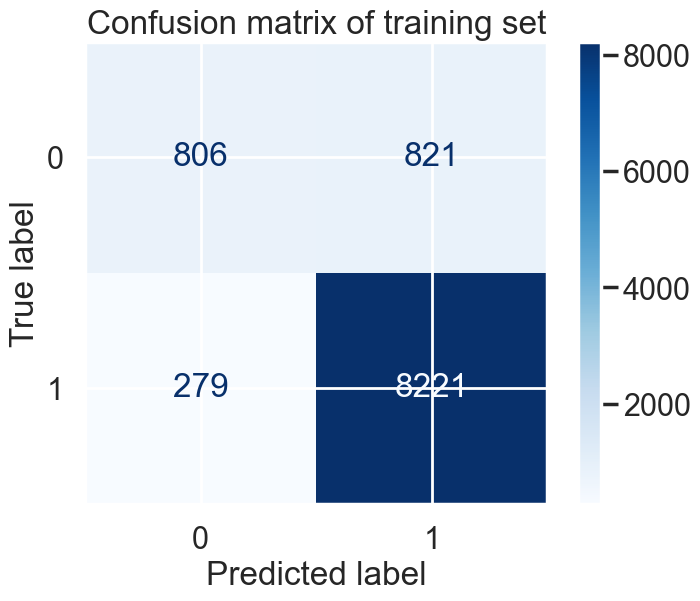

In [1361]:
# Plot confusion matrix of training set
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clfbm,
                      xbm,
                      ybm,
                      display_labels=list(set(ybm_test)),
                      cmap=plt.cm.Blues) 
plt.title('Confusion matrix of training set')
plt.show()  

In [1362]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix
ybm_pred_train = clfbm.predict(xbm_train)
print("Classification report on Train data\n=======================")
print(classification_report(y_true=ybm_train, y_pred=ybm_pred_train))
print("Confusion matrix on Train data\n=======================")

print(confusion_matrix(y_true=ybm_train, y_pred=ybm_pred_train))

Classification report on Train data
              precision    recall  f1-score   support

           0       0.75      0.50      0.60      1318
           1       0.91      0.97      0.94      6783

    accuracy                           0.89      8101
   macro avg       0.83      0.73      0.77      8101
weighted avg       0.88      0.89      0.88      8101

Confusion matrix on Train data
[[ 654  664]
 [ 220 6563]]


In [1363]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix
ybm_pred_test = clfbm.predict(xbm_test)
print("Classification report on Test data\n=======================")
print(classification_report(y_true=ybm_test, y_pred=ybm_pred_test))
print("Confusion matrix on Test data\n=======================")

print(confusion_matrix(y_true=ybm_test, y_pred=ybm_pred_test))

Classification report on Test data
              precision    recall  f1-score   support

           0       0.72      0.49      0.58       309
           1       0.91      0.97      0.94      1717

    accuracy                           0.89      2026
   macro avg       0.82      0.73      0.76      2026
weighted avg       0.88      0.89      0.88      2026

Confusion matrix on Test data
[[ 152  157]
 [  59 1658]]


### **Check Values of Numerical Features**

In [1364]:
df.isnull().sum()

Customer_Age                0
Dependent_count             0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
Gender                      0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Attrition_Flag              0
dtype: int64

In [1365]:
df.describe()

Customer_Age  Dependent_count  Months_on_book  \
count  10127.000000     10127.000000    10127.000000   
mean      46.325960         2.346203       35.928409   
std        8.016814         1.298908        7.986416   
min       26.000000         0.000000       13.000000   
25%       41.000000         1.000000       31.000000   
50%       46.000000         2.000000       36.000000   
75%       52.000000         3.000000       40.000000   
max       73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count           10127.000000  10127.000000         10127.000000   
mean                2.455317   8631.953698          1162.814061   
std                 1.106225   9088.776650           814.987335   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2555.000000           359.000000   
50%                 2.000000   4549.000000          1276.000000   
75%                 3.000000  11067.500000          1784.000000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count     10127.000000          10127.000000     10127.000000    10127.000000   
mean       7469.139637              0.759941      4404.086304       64.858695   
std        9090.685324              0.219207      3397.129254       23.472570   
min           3.000000              0.000000       510.000000       10.000000   
25%        1324.500000              0.631000      2155.500000       45.000000   
50%        3474.000000              0.736000      3899.000000       67.000000   
75%        9859.000000              0.859000      4741.000000       81.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  Attrition_Flag  
count         10127.000000           10127.000000    10127.000000  
mean              0.712222               0.274894        0.839340  
std               0.238086               0.275691        0.367235  
min               0.000000               0.000000        0.000000  
25%               0.582000               0.023000        1.000000  
50%               0.702000               0.176000        1.000000  
75%               0.818000               0.503000        1.000000  
max               3.714000               0.999000        1.000000

<AxesSubplot:xlabel='Avg_Utilization_Ratio', ylabel='Count'>

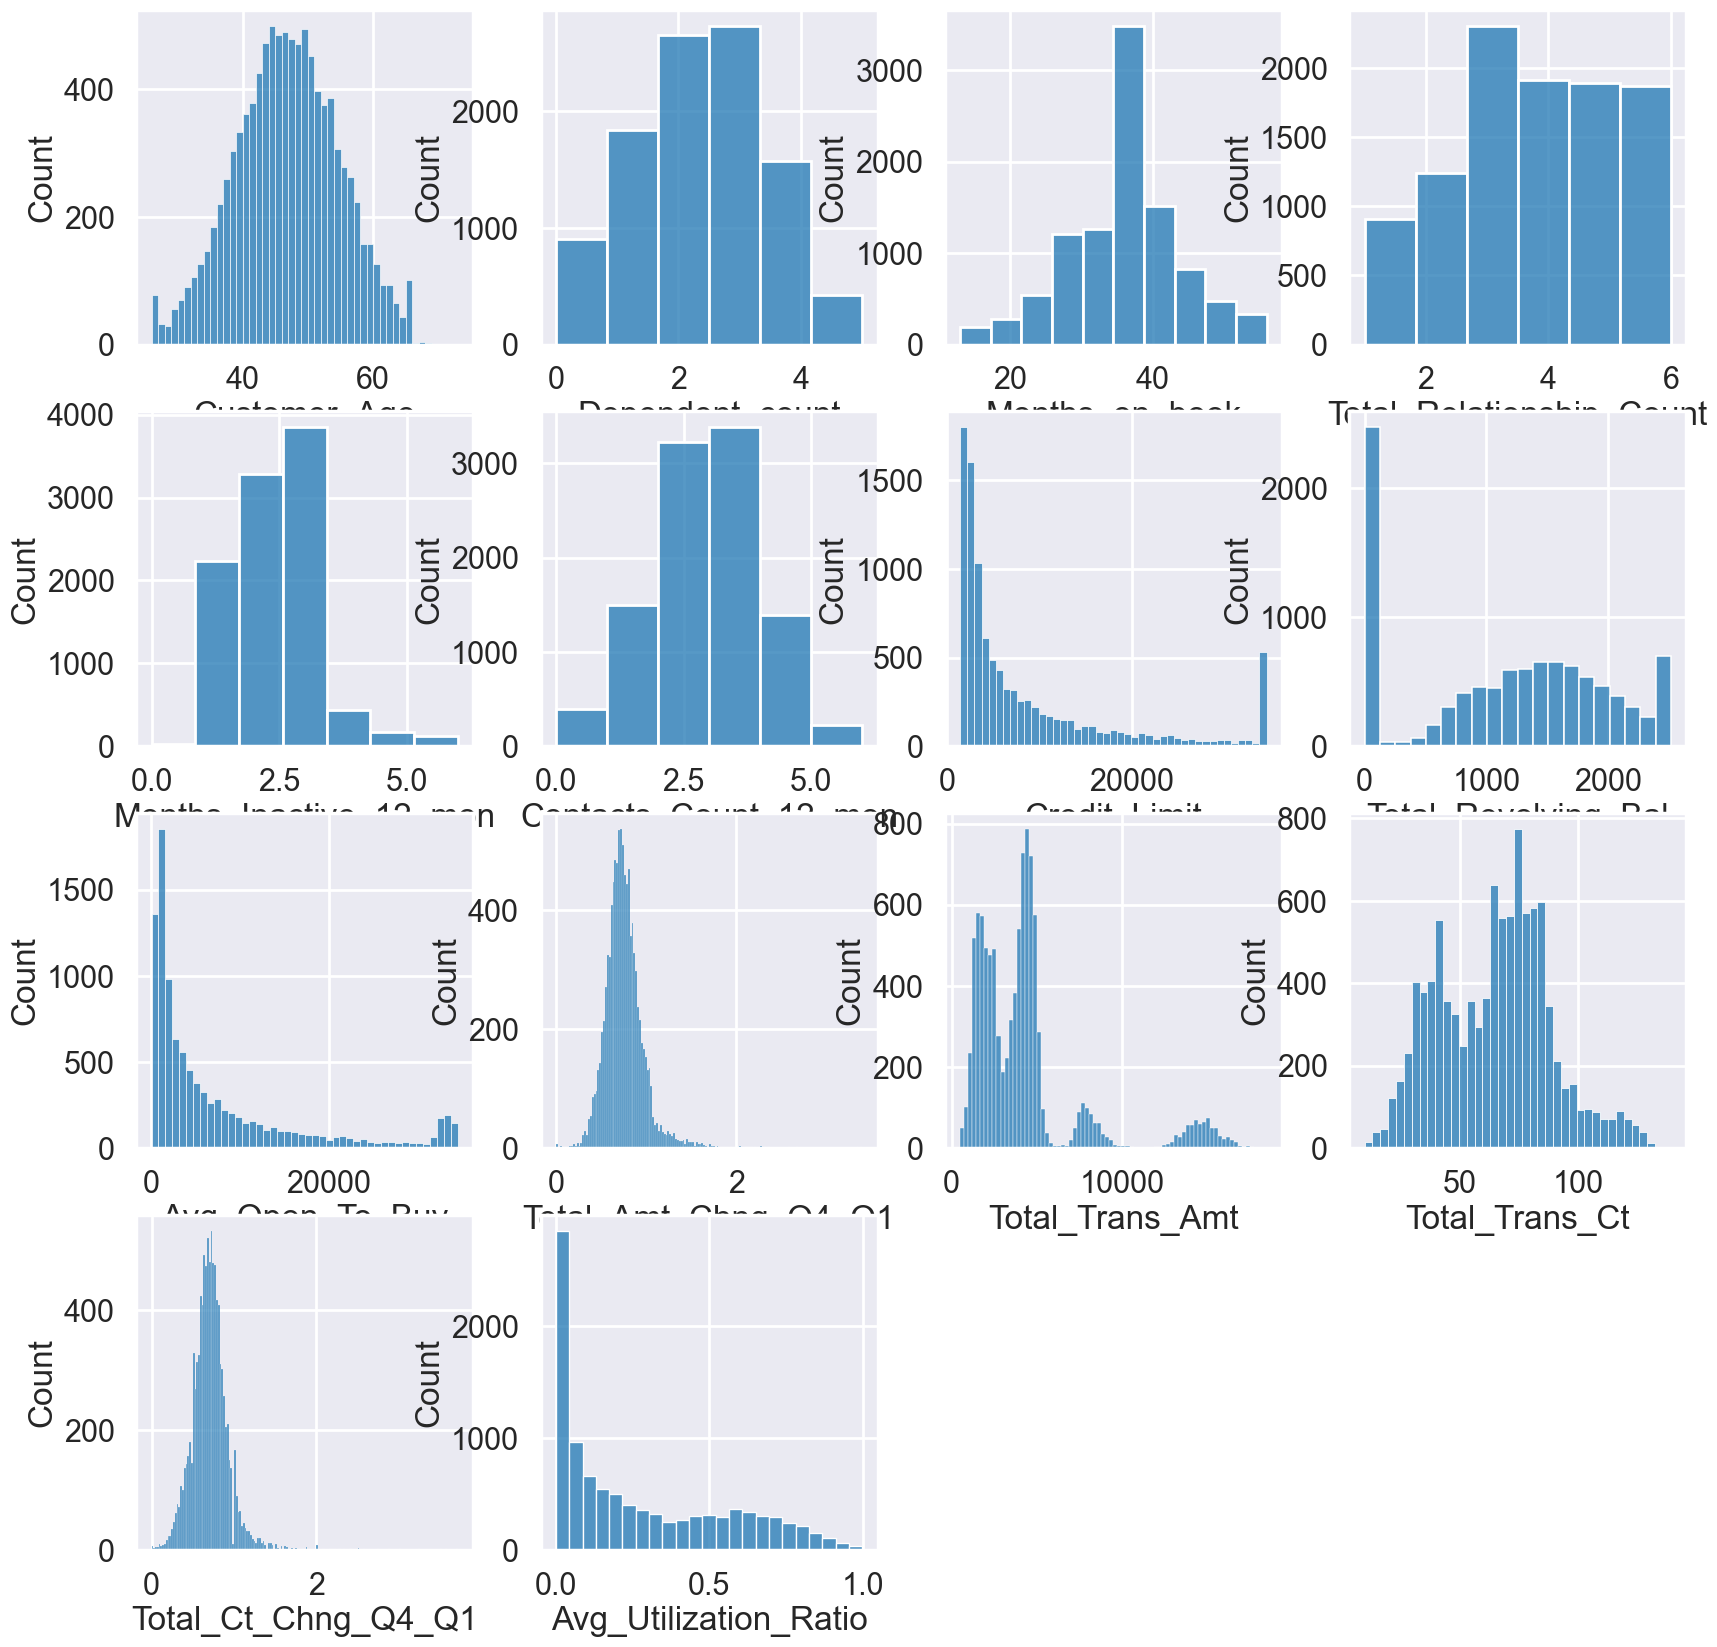

In [1366]:
# plot numerical data
plt.figure(figsize=(20,20))
plt.subplot(441) 
sns.histplot(df['Customer_Age'])
plt.subplot(442) 
sns.histplot(df['Dependent_count'],bins=6)
plt.subplot(443) 
sns.histplot(df['Months_on_book'],bins=10)
plt.subplot(444) 
sns.histplot(df['Total_Relationship_Count'],bins=6)
plt.subplot(445) 
sns.histplot(df['Months_Inactive_12_mon'],bins=7)
plt.subplot(446) 
sns.histplot(df['Contacts_Count_12_mon'],bins=6)
plt.subplot(447) 
sns.histplot(df['Credit_Limit'])
plt.subplot(448) 
sns.histplot(df['Total_Revolving_Bal'])
plt.subplot(449) 
sns.histplot(df['Avg_Open_To_Buy'])
plt.subplot(4,4,10) 
sns.histplot(df['Total_Amt_Chng_Q4_Q1'])
plt.subplot(4,4,11)
sns.histplot(df['Total_Trans_Amt'])
plt.subplot(4,4,12)
sns.histplot(df['Total_Trans_Ct'])
plt.subplot(4,4,13)
sns.histplot(df['Total_Ct_Chng_Q4_Q1'])
plt.subplot(4,4,14)
sns.histplot(df['Avg_Utilization_Ratio'])

What we got from plotting values of numerical features:

|Feature Names|Normally Distributed|
|-|-|
|Customer_Age|Yes|
|Dependent_Count|Yes|
|Months_on_book|Yes|
|Total_Relationship_Count|No|
|Months_Inactive_12_mon|Almost|
|Contacts_Count_12_mon|Yes|
|Credit_Limit|No|
|Total_Revolving_Bal|No|
|Avg_Open_To_Buy|No|
|Total_Amt_Chng_Q4_Q1|Almost|
|Total_Trans_Amt|No|
|Total_Trans_Ct|Almost|
|Total_Ct_Chng_Q4_Q1|Almost|
|Avg_Utilization_Ratio|No|

### **Check Values of Categorical Features**

In [1367]:
df['Gender'].value_counts()

F    5358
M    4769
Name: Gender, dtype: int64

In [1368]:
# Calculate Percentage of Gender
100*df['Gender'].value_counts()/len(df)

F    52.908068
M    47.091932
Name: Gender, dtype: float64

In [1369]:
df['Education_Level'].value_counts()

Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

In [1370]:
# Calculate Percentage of Education Level
100*df['Education_Level'].value_counts()/len(df)

Graduate         30.887726
High School      19.877555
Unknown          14.999506
Uneducated       14.683519
College          10.002962
Post-Graduate     5.095290
Doctorate         4.453441
Name: Education_Level, dtype: float64

In [1371]:
df['Marital_Status'].value_counts()

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64

In [1372]:
# Calculate Percentage of Marital Status
100*df['Marital_Status'].value_counts()/len(df)

Married     46.282216
Single      38.935519
Unknown      7.396070
Divorced     7.386195
Name: Marital_Status, dtype: float64

In [1373]:
df['Income_Category'].value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

In [1374]:
# Calculate Percentage of Income Category
100*df['Income_Category'].value_counts()/len(df)

Less than $40K    35.163425
$40K - $60K       17.675521
$80K - $120K      15.157500
$60K - $80K       13.844179
Unknown           10.980547
$120K +            7.178829
Name: Income_Category, dtype: float64

In [1375]:
df['Card_Category'].value_counts()

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64

In [1376]:
# Calculate Percentage of Card Category
100*df['Card_Category'].value_counts()/len(df)

Blue        93.176656
Silver       5.480399
Gold         1.145453
Platinum     0.197492
Name: Card_Category, dtype: float64

<AxesSubplot:title={'center':'Card Category'}>

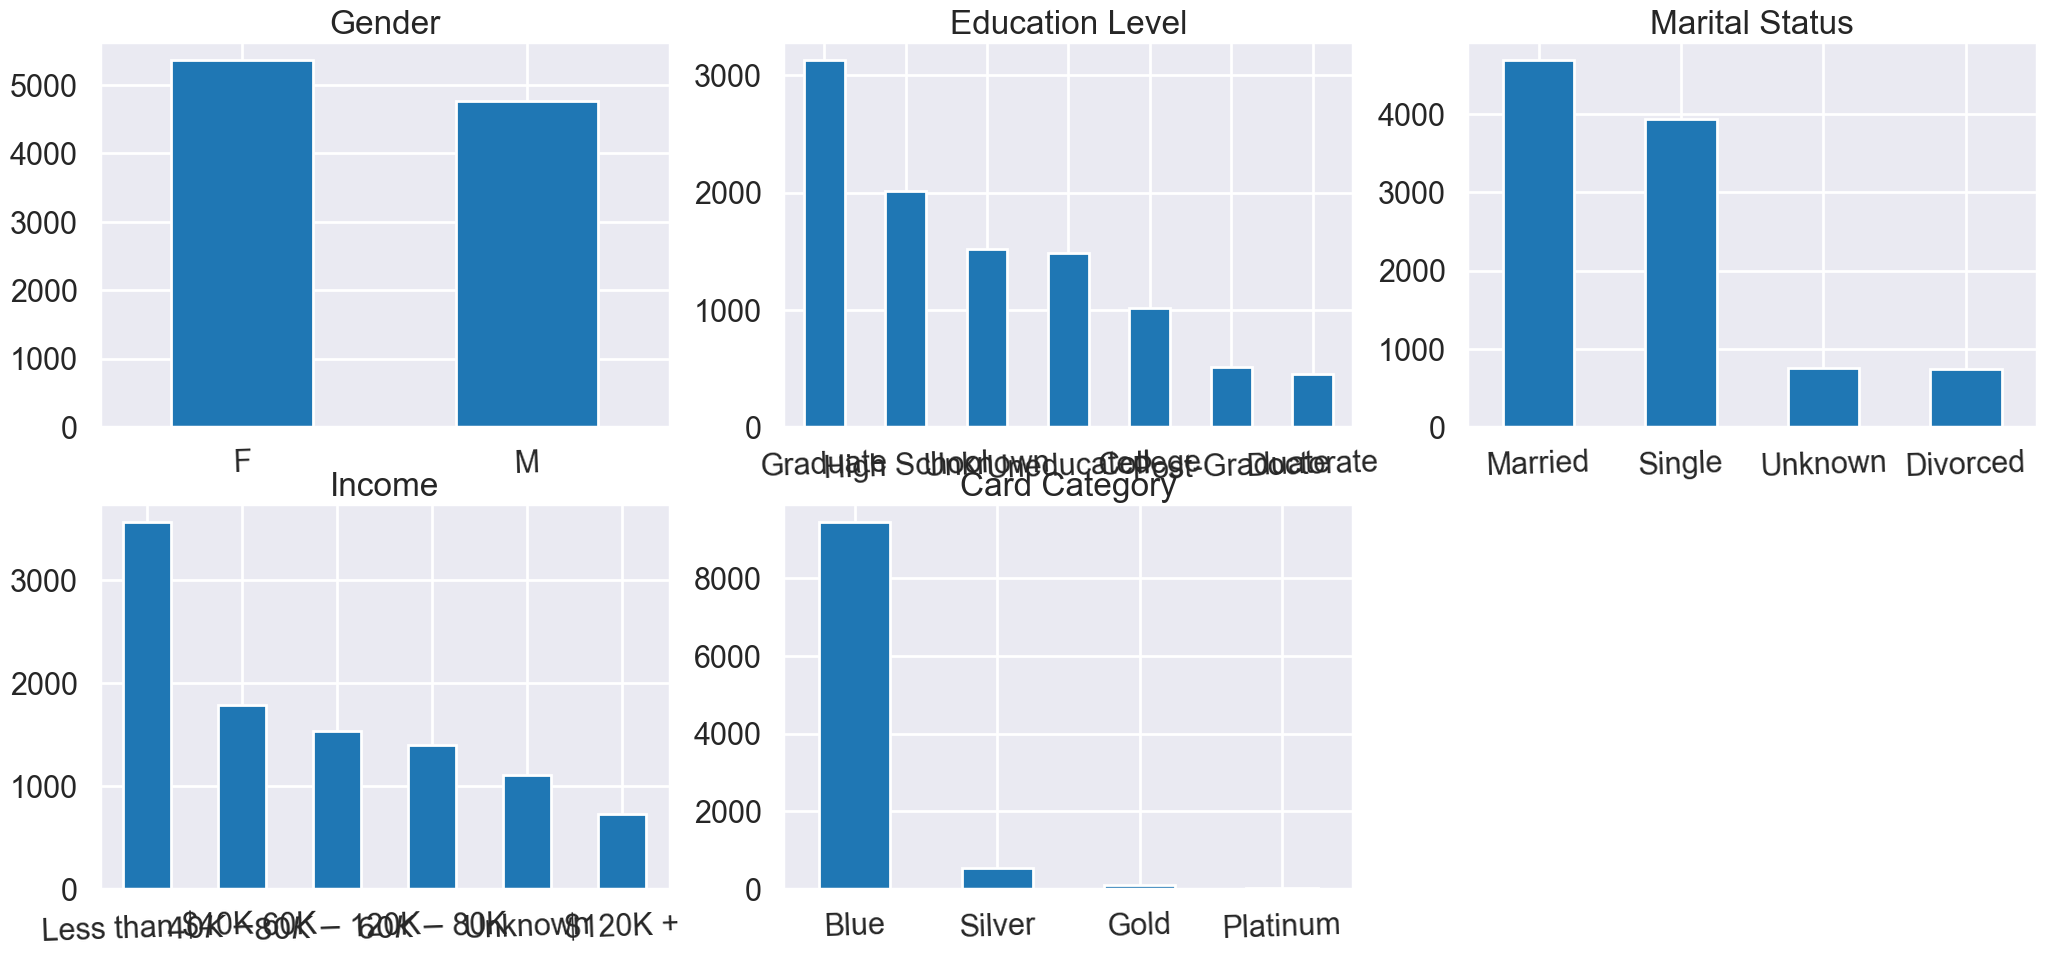

In [1377]:
# plot categorical data
plt.figure(figsize=(25,11))
plt.subplot(231) 
df['Gender'].value_counts(normalize=False).plot.bar(title= 'Gender',rot=2) 
plt.subplot(232) 
df['Education_Level'].value_counts(normalize=False).plot.bar(title= 'Education Level',rot=2) 
plt.subplot(233) 
df['Marital_Status'].value_counts(normalize=False).plot.bar(title= 'Marital Status',rot=2)
plt.subplot(234) 
df['Income_Category'].value_counts(normalize=False).plot.bar(title= 'Income',rot=2)
plt.subplot(235) 
df['Card_Category'].value_counts(normalize=False).plot.bar(title= 'Card Category',rot=2)

What we got from plotting values of categorical features:

|Feature Names|What we got|
|-|-|
|Gender|There are nearly the same amount of male and female.|
|Education_Level|Most of the people in this dataset are 'Graduate' and around 15% of the people are 'Unknown'|
|Marital_Status|46% of this data are 'Married', 39% are 'Single' and the rest are 'Unknown' or 'Divorced'|
|Income_Category|Most people in this dataset have 'less than 40K' income|
|Card_Category|People in this dataset mostly hold blue cards (more than 93%) and the rest hold the other 3 cards (less than 7%).|

### **Check Behaviour of Attrition_Flag**

In [1378]:
dfAtt = df[df['Attrition_Flag'] == 0]
dfAtt

Customer_Age  Dependent_count  Months_on_book  \
21               62                0              49   
39               66                0              56   
51               54                1              40   
54               56                2              36   
61               48                2              35   
...             ...              ...             ...   
10119            55                3              47   
10123            41                2              25   
10124            44                1              36   
10125            30                2              36   
10126            43                2              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
21                            2                       3   
39                            5                       4   
51                            2                       3   
54                            1                       3   
61                            2                       4   
...                         ...                     ...   
10119                         4                       3   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
21                         3        1438.3                    0   
39                         3        7882.0                  605   
51                         1        1438.3                  808   
54                         3       15769.0                    0   
61                         4       34516.0                    0   
...                      ...           ...                  ...   
10119                      3       14657.0                 2517   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
21              1438.3                 1.047              692              16   
39              7277.0                 1.052              704              16   
51               630.3                 0.997              705              19   
54             15769.0                 1.041              602              15   
61             34516.0                 0.763              691              15   
...                ...                   ...              ...             ...   
10119          12140.0                 0.166             6009              53   
10123           2091.0                 0.804             8764              69   
10124           5409.0                 0.819            10291              60   
10125           5281.0                 0.535             8395              62   
10126           8427.0                 0.703            10294              61   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio Gender Education_Level  \
21                   0.600                  0.000      F        Graduate   
39                   0.143                  0.077      F       Doctorate   
51                   0.900                  0.562      F        Graduate   
54                   0.364                  0.000      M        Graduate   
61                   0.500                  0.000      M        Graduate   
...                    ...                    ...    ...             ...   
10119                0.514                  0.172      F      Uneducated   
10123                0.683                  0.511      M         Unknown   
10124                0.818                  0.000      F     High School   
10125                0.722                  0.000      M        Graduate   
10126      

In [1379]:
dfExist = df[df['Attrition_Flag'] == 1]
dfExist

Customer_Age  Dependent_count  Months_on_book  \
0                45                3              39   
1                49                5              44   
2                51                3              36   
3                40                4              34   
4                40                3              21   
...             ...              ...             ...   
10116            46                5              36   
10117            57                2              40   
10120            54                1              34   
10121            56                1              50   
10122            50                2              40   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                             4                       1   
3                             3                       4   
4                             5                       1   
...                         ...                     ...   
10116                         1                       2   
10117                         6                       3   
10120                         5                       2   
10121                         4                       1   
10122                         3                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
1                          2        8256.0                  864   
2                          0        3418.0                    0   
3                          1        3313.0                 2517   
4                          0        4716.0                    0   
...                      ...           ...                  ...   
10116                      3       13187.0                 2241   
10117                      4       17925.0                 1909   
10120                      0       13940.0                 2109   
10121                      4        3688.0                  606   
10122                      3        4003.0                 1851   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0              11914.0                 1.335             1144              42   
1               7392.0                 1.541             1291              33   
2               3418.0                 2.594             1887              20   
3                796.0                 1.405             1171              20   
4               4716.0                 2.175              816              28   
...                ...                   ...              ...             ...   
10116          10946.0                 0.689            15354             112   
10117          16016.0                 0.712            17498             111   
10120          11831.0                 0.660            15577             114   
10121           3082.0                 0.570            14596             120   
10122           2152.0                 0.703            15476             117   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio Gender Education_Level  \
0                    1.625                  0.061      M     High School   
1                    3.714                  0.105      F        Graduate   
2                    2.333                  0.000      M        Graduate   
3                    2.333                  0.760      F     High School   
4                    2.500                  0.000      M      Uneducated   
...                    ...                    ...    ...             ...   
10116                0.931                  0.170      M         College   
10117                0.820                  0.106      M        Graduate   
10120                0.754                  0.151      M     High School   
10121                0.791                  0.164      F        Graduate   
10122      

### **Plot Features of Attrited Customers**

<AxesSubplot:title={'center':'Card Category'}>

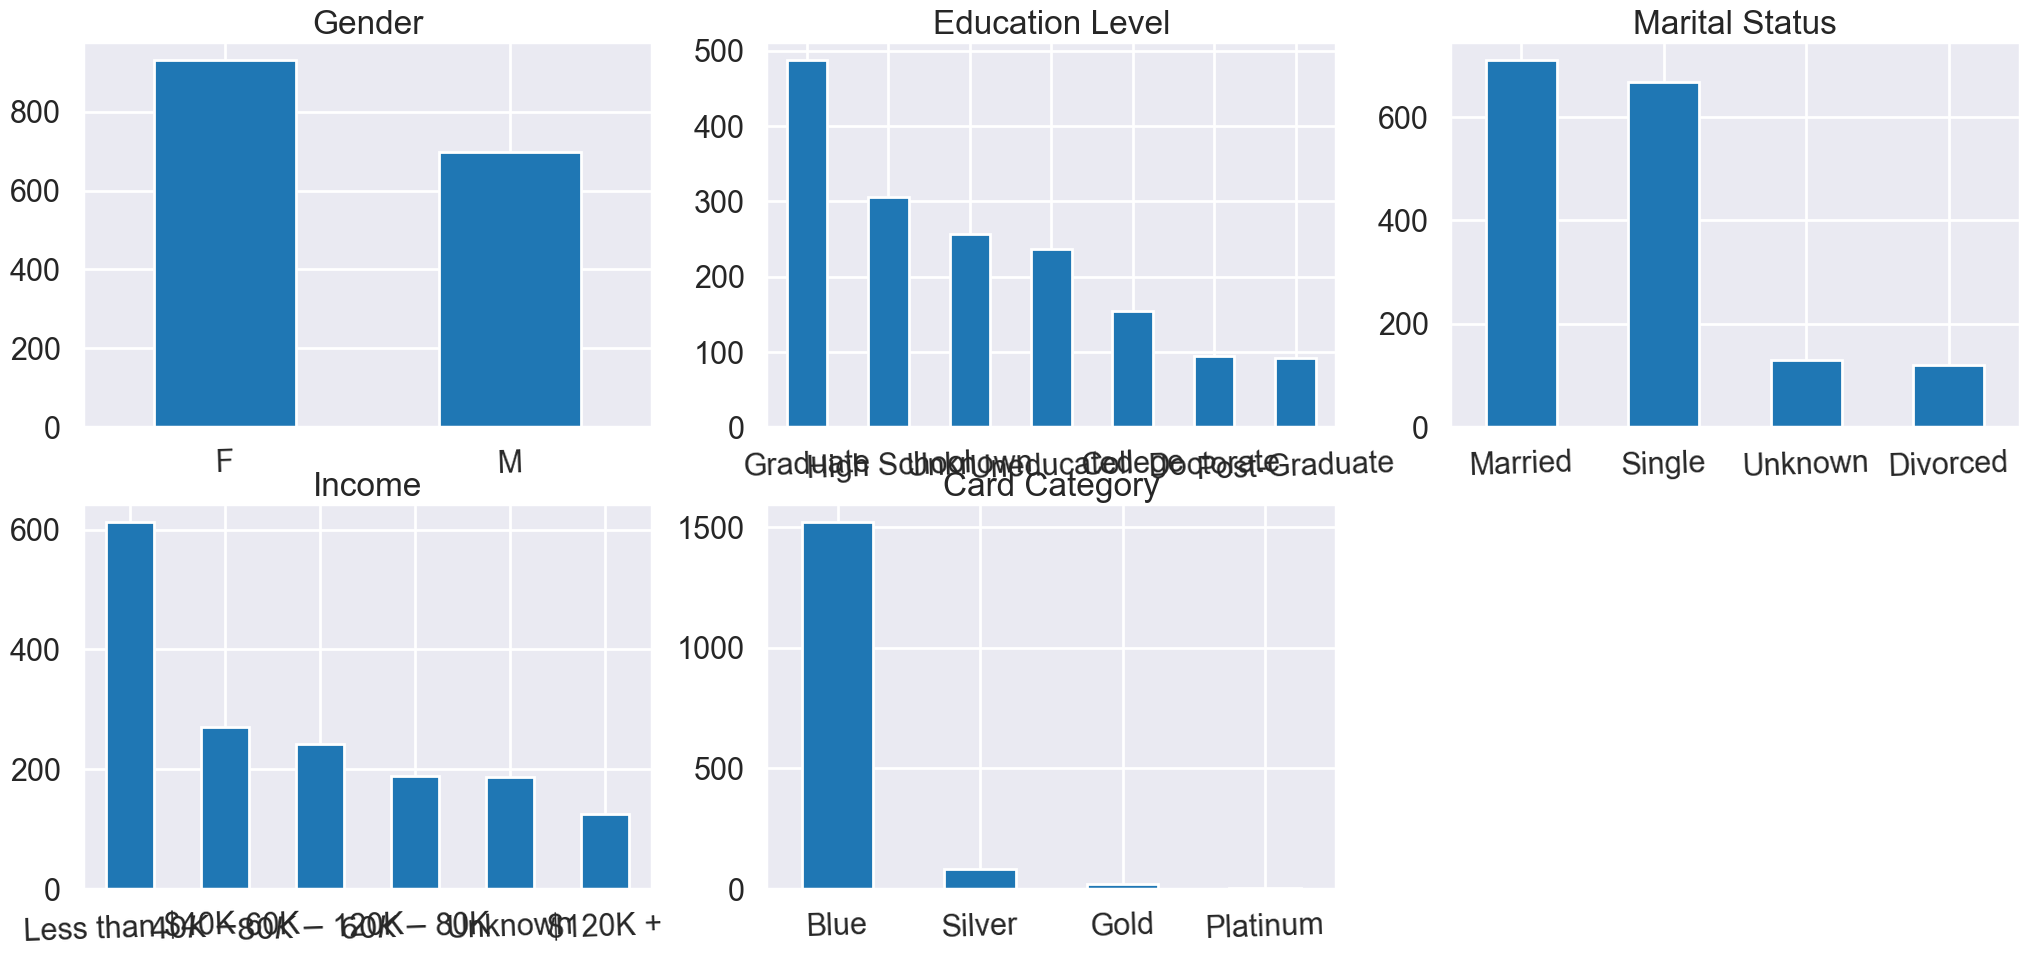

In [1380]:
# plot categorical data
plt.figure(figsize=(25,11))
plt.subplot(231) 
dfAtt['Gender'].value_counts(normalize=False).plot.bar(title= 'Gender',rot=2) 
plt.subplot(232) 
dfAtt['Education_Level'].value_counts(normalize=False).plot.bar(title= 'Education Level',rot=2) 
plt.subplot(233) 
dfAtt['Marital_Status'].value_counts(normalize=False).plot.bar(title= 'Marital Status',rot=2)
plt.subplot(234) 
dfAtt['Income_Category'].value_counts(normalize=False).plot.bar(title= 'Income',rot=2)
plt.subplot(235) 
dfAtt['Card_Category'].value_counts(normalize=False).plot.bar(title= 'Card Category',rot=2)

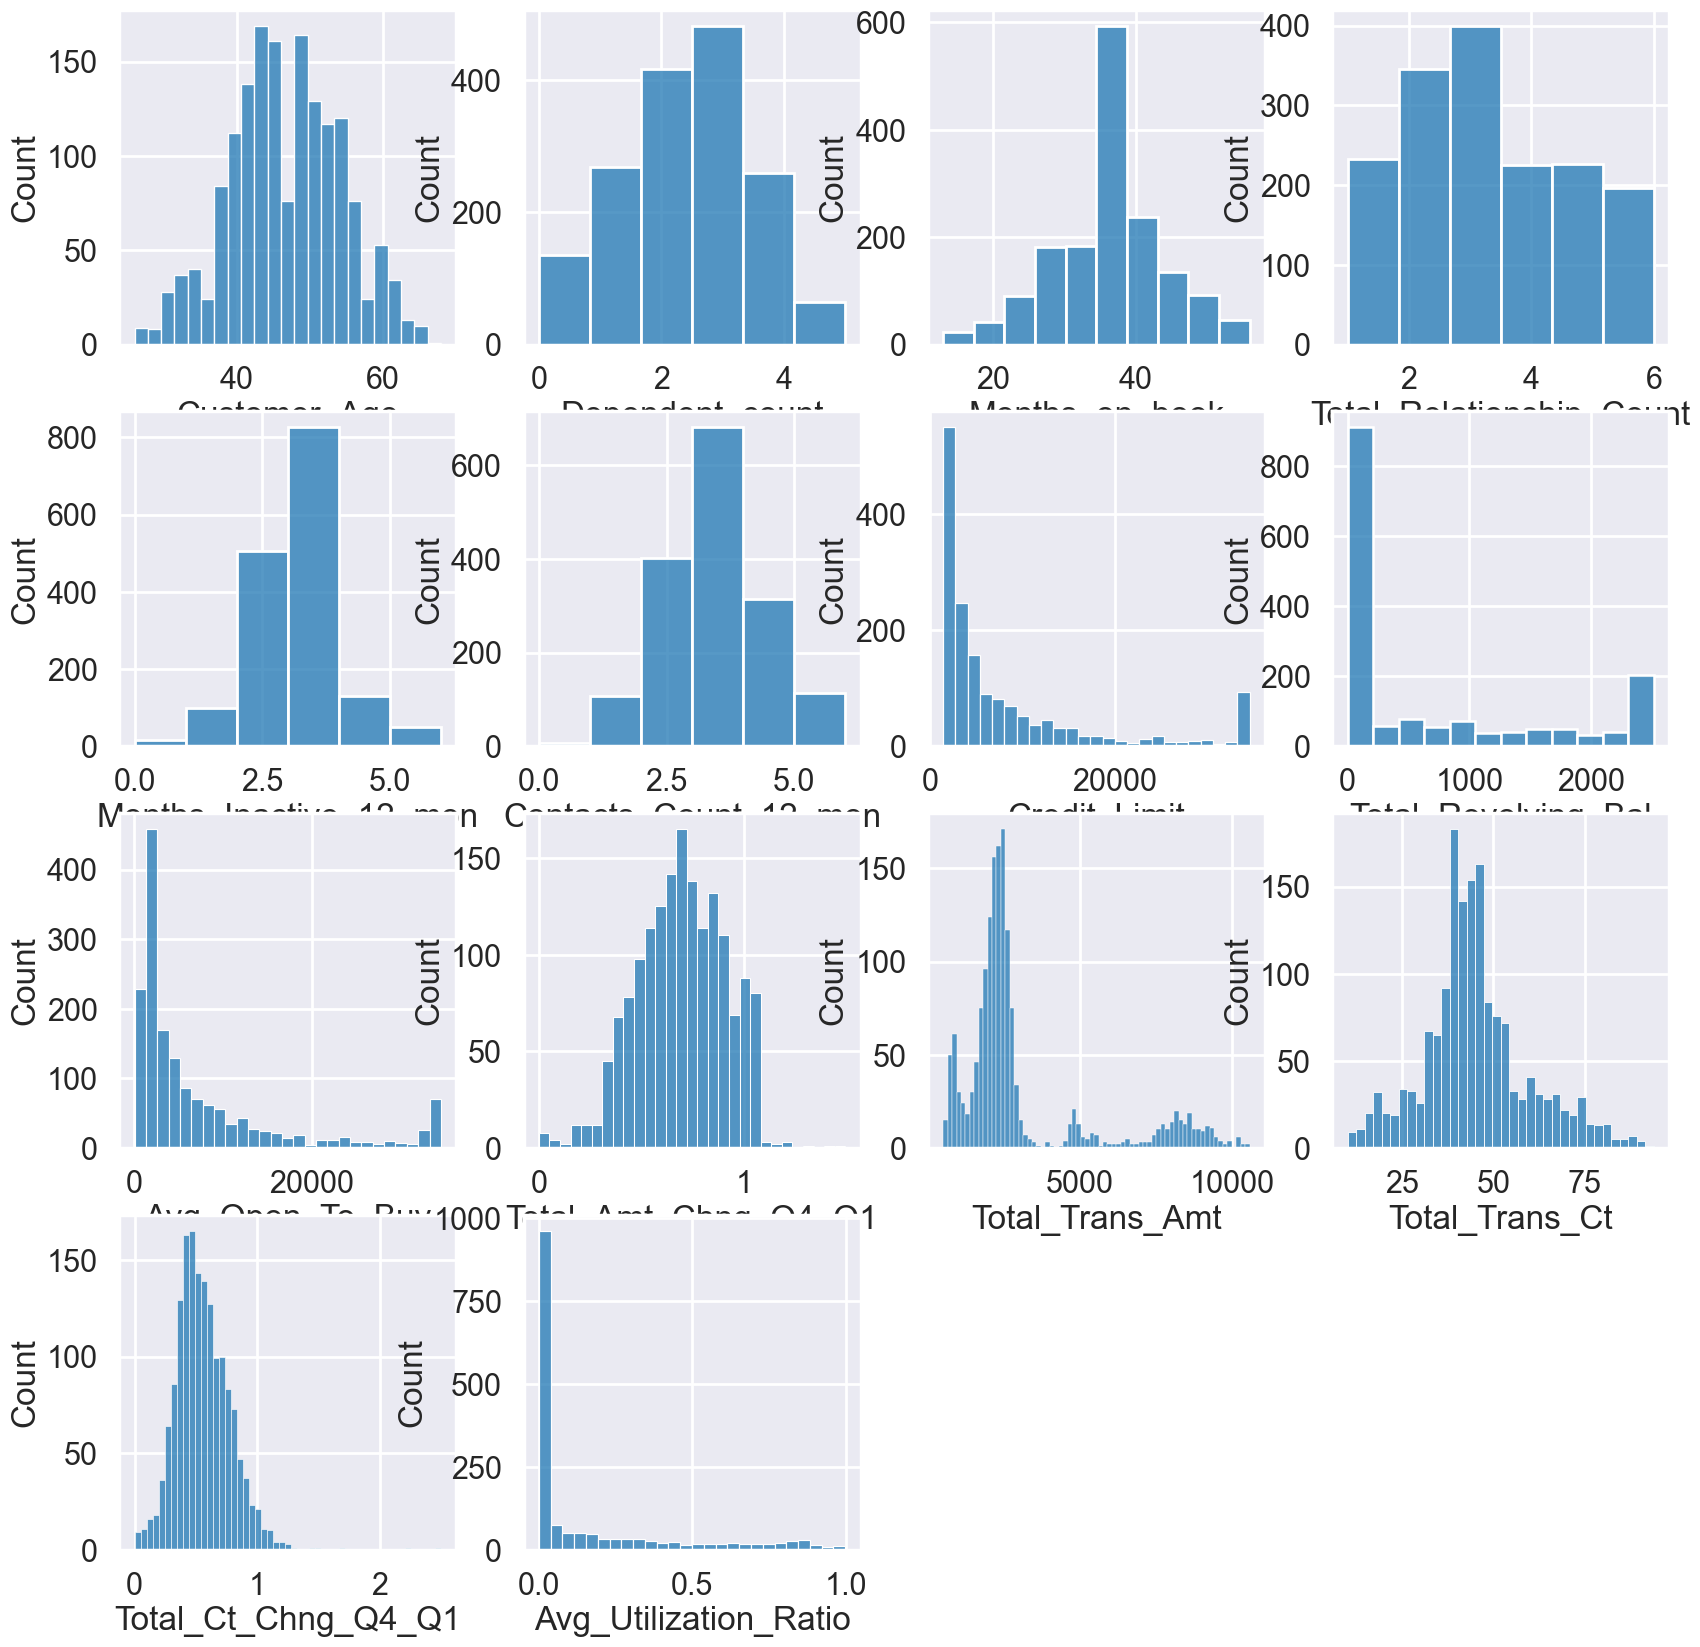

In [1381]:
# plot numerical data
plt.figure(figsize=(20,20))

for idx, col in enumerate(dfNum.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(4,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(dfAtt[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(dfAtt[col],bins=10)
        else:
            sns.histplot(dfAtt[col])

### **Plot Features of Existing Customers**

<AxesSubplot:title={'center':'Card Category'}>

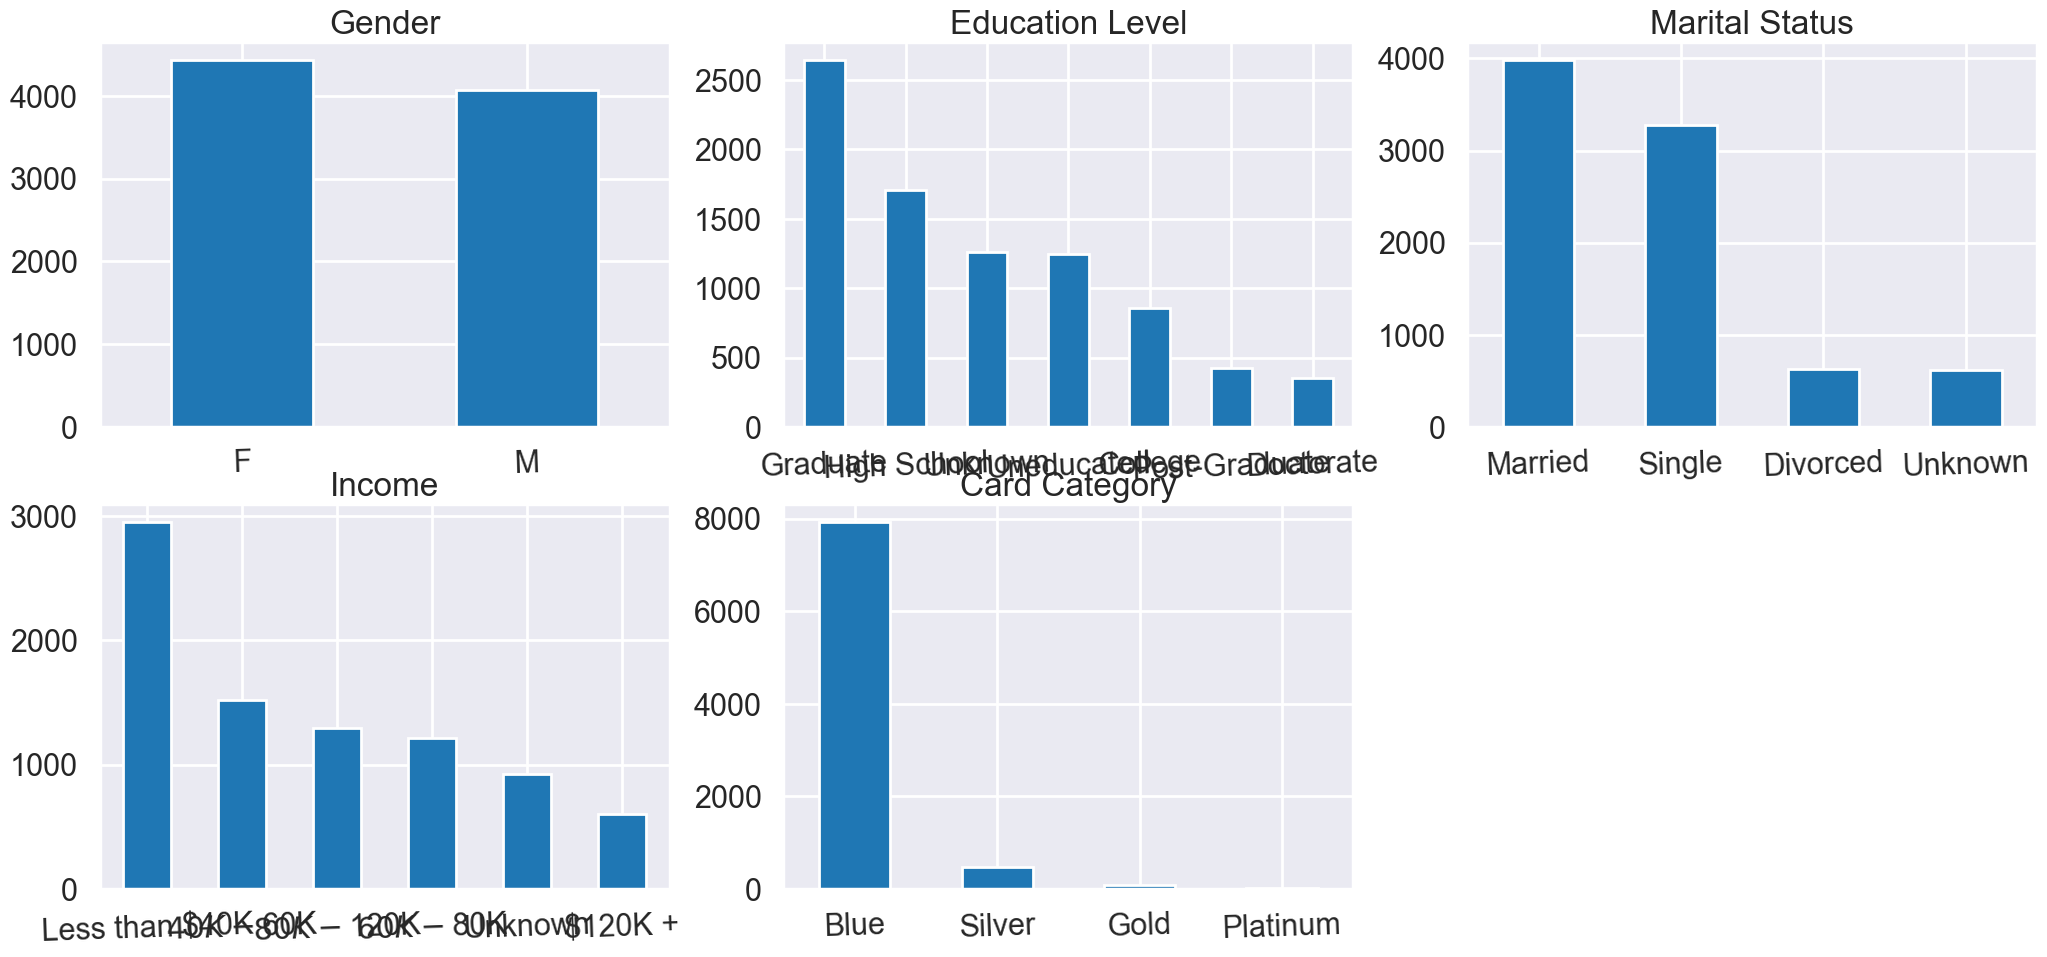

In [1382]:
# plot categorical data
plt.figure(figsize=(25,11))
plt.subplot(231) 
dfExist['Gender'].value_counts(normalize=False).plot.bar(title= 'Gender',rot=2) 
plt.subplot(232) 
dfExist['Education_Level'].value_counts(normalize=False).plot.bar(title= 'Education Level',rot=2) 
plt.subplot(233) 
dfExist['Marital_Status'].value_counts(normalize=False).plot.bar(title= 'Marital Status',rot=2)
plt.subplot(234) 
dfExist['Income_Category'].value_counts(normalize=False).plot.bar(title= 'Income',rot=2)
plt.subplot(235) 
dfExist['Card_Category'].value_counts(normalize=False).plot.bar(title= 'Card Category',rot=2)

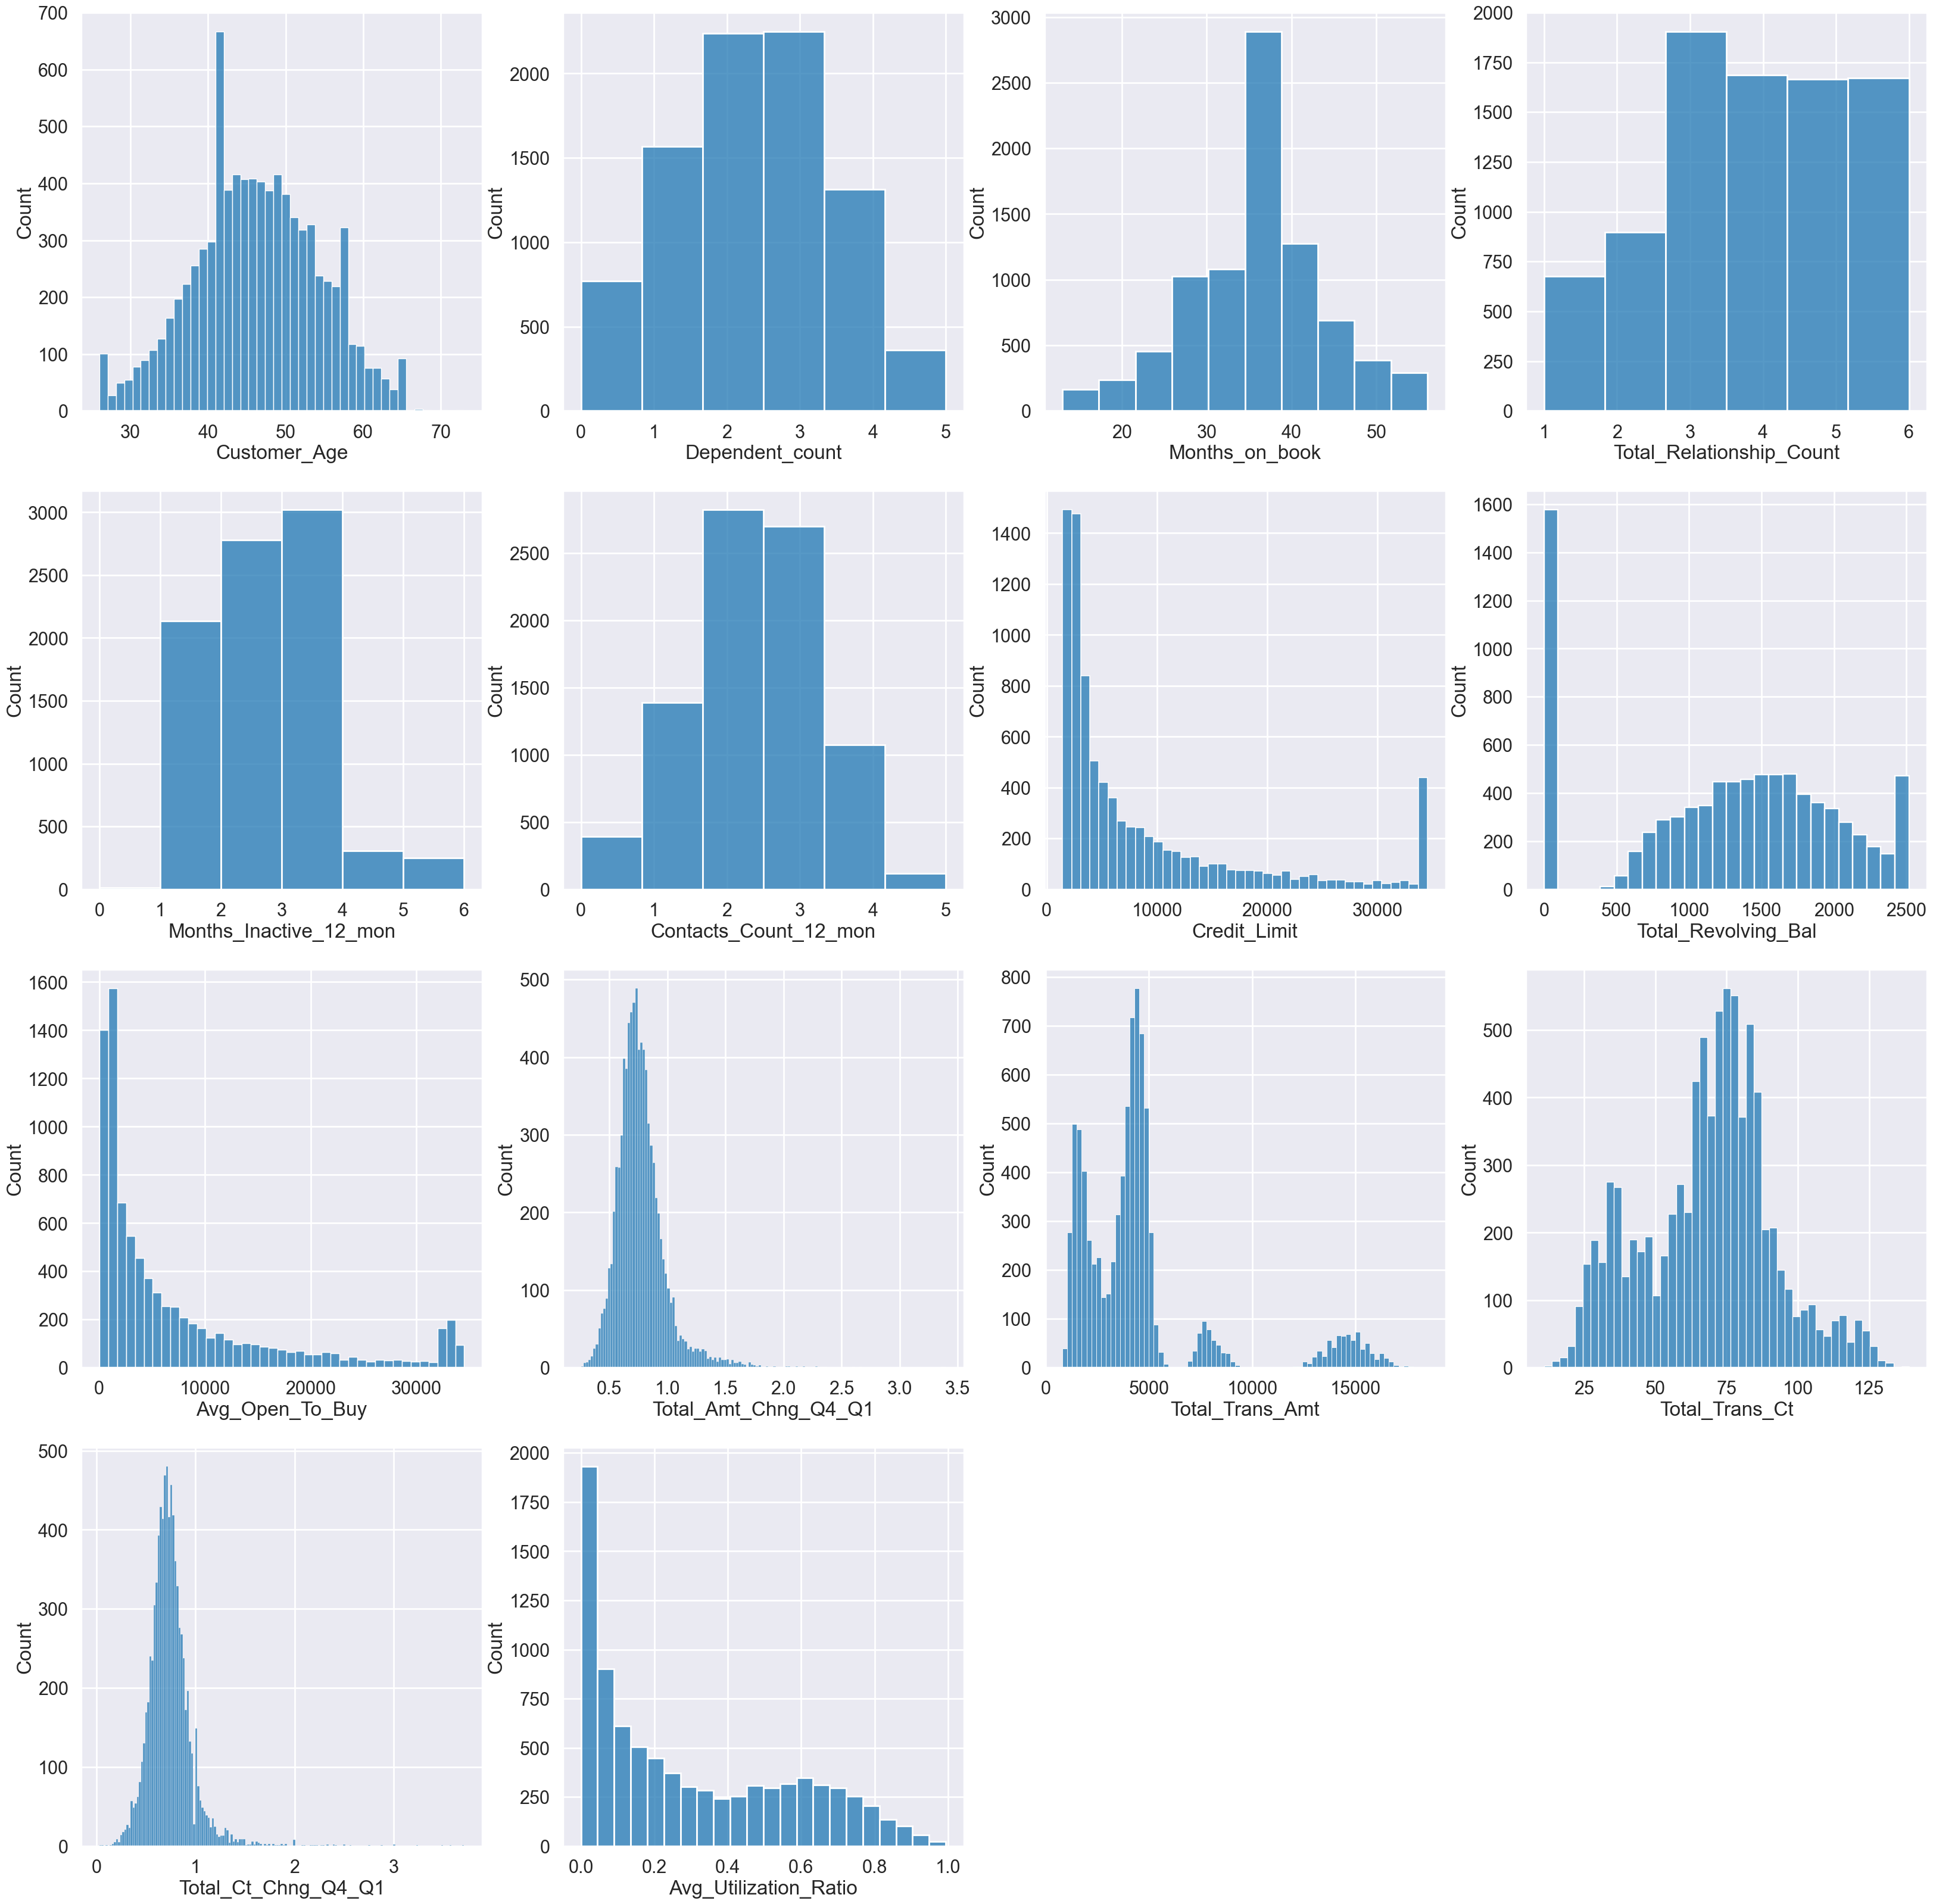

In [1383]:
# plot numerical data
plt.figure(figsize=(40,40))

for idx, col in enumerate(dfNum.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(4,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(dfExist[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(dfExist[col],bins=10)
        else:
            sns.histplot(dfExist[col])

### **Pairplot Interesting Features**

In [1384]:
# sns.pairplot(df[['Attrition_Flag','Total_Relationship_Count', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1','Avg_Utilization_Ratio']], diag_kind="hist", hue="Attrition_Flag")

Good and Bad things of this dataset:

|Good Things|Explanation|
|-|-|
|Data Distribution|Most Numerical data are normally distributed.|
|Filled Data in Numerical Features|There are no missing data (NaN) or unknown in numerical features of this dataset.|

<hr>

|Bad Things|Explanation|
|-|-|
|Data Explanation|Most features come with little to no explanation or bad explanation, eg. Avg_Open_To_Buy.|
|'Card_Category' Features|This feature's data are mostly 'Blue' (around 93%).|
|Unknown Data|Unclear explanation of what unknown data means and there are a lot of them in categorical features.|
|Data Variation|As we can see when pairplotting, variance between features are quite low and variance within class are quite high, which means that data variation is very bad.|

**NOTE**: For all 'Unknown' data in categorical features, we assumed 'Unknown' as a type of data because there are quite a lot of 'Unknown' data.

Furthermore, because we are dealing with a credit card dataset, which can be considered as a dataset provided by a bank, those 'Unknown' data might be undisclosed information of the customers.

### **Check Correlation between Numerical Features**

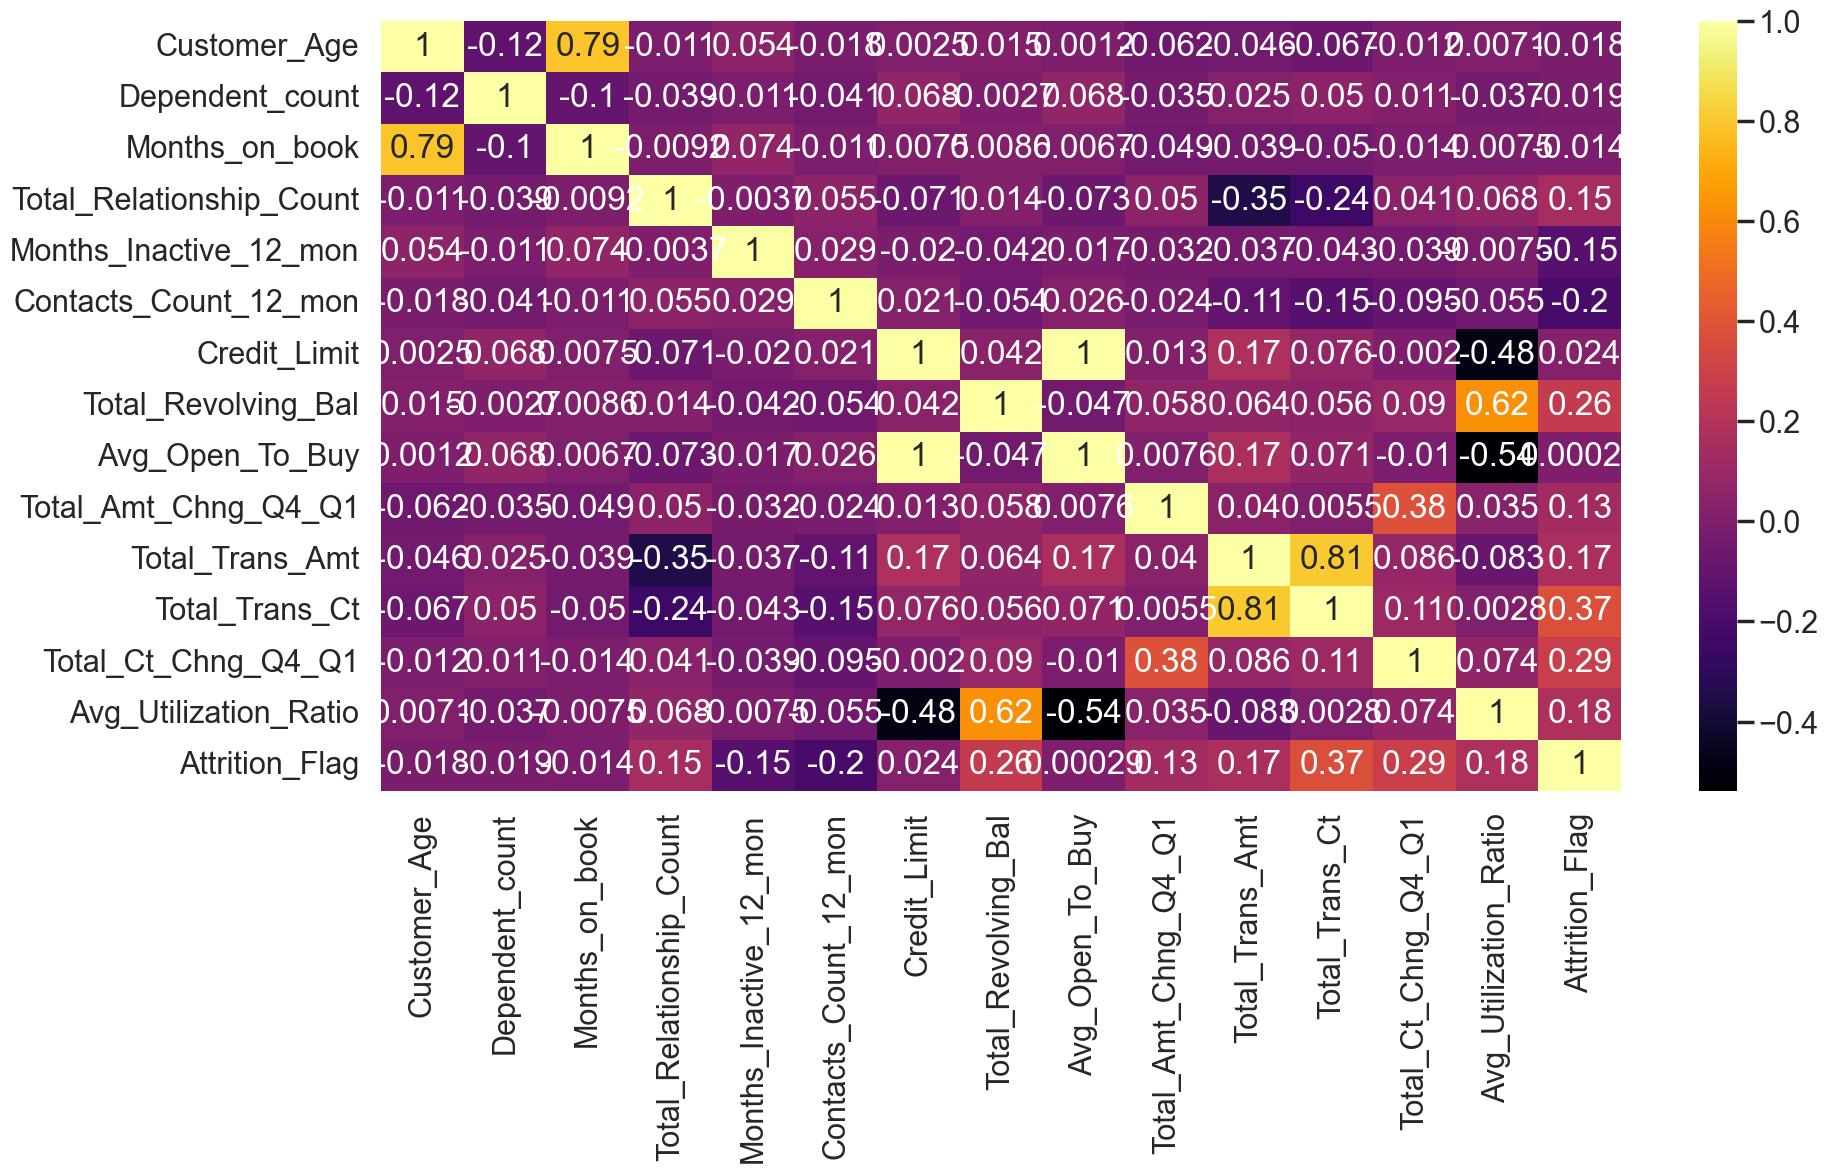

In [1385]:
checkCorrFF(df)

From the heatmap above, we can drop these features:

|Feature Names|Reasons|
|-|-|
|Customer_Age|Looking at the heatmap, it correlates with 'Months_on_Book' (79%). We assumed that 'Months_on_Book' is more useful than 'Customer_Age'.|
|Credit_Limit|Looking at the heatmap, 'Credit_Limit' and 'Avg_Open_To_Buy' perfectly correlate to each other.|
|Total_Trans_Amt|Looking at the heatmap, it correlates with 'Total_Trans_Ct' (81%) and correlates with other features quite a lot.|
|Total_Amt_Chng_Q4_Q1|Looking at the heatmap, it correlates with 'Total_Ct_Chng_Q4_Q1' (38%).|
|Avg_Utilization_Ratio|Looking at the heatmap, it correlates too much with 3 features, 'Credit_Limit', 'Total_Revolving_Bal' and 'Avg_Open_To_Buy'.|

# **Resampling Method 1** : SMOTE (Synthetic Minority Oversampling TEchnique)
<hr>

## **Data Preprocessing**
### **Label Encoding**

<AxesSubplot:ylabel='Type'>

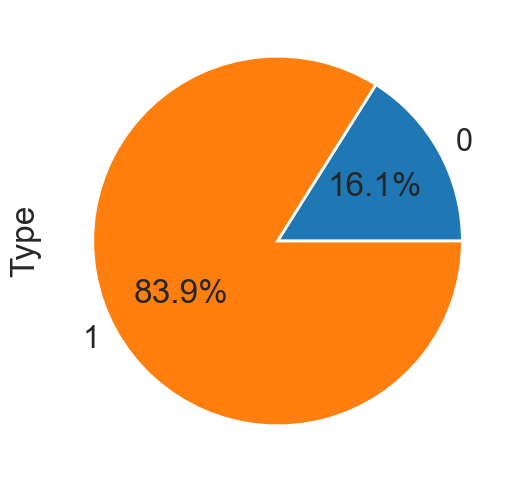

In [1386]:
sns.set_style("darkgrid")
sns.set_context("poster")
plt.rcParams["figure.figsize"] = [8,6]

df.groupby('Attrition_Flag').size().plot(kind='pie',
                                                y = "Attrition_Flag",
                                                label = "Type",
                                                autopct='%1.1f%%')

In [1387]:
df_LE = df.copy()
le_Gender = LabelEncoder()
le_Education_Level = LabelEncoder()
le_Marital_Status = LabelEncoder()
le_Income_Category = LabelEncoder()
le_Card_Category = LabelEncoder()

df_LE['Gender'] = le_Gender.fit_transform(df_LE['Gender'])
df_LE['Education_Level'] = le_Gender.fit_transform(df_LE['Education_Level'])
df_LE['Marital_Status'] = le_Gender.fit_transform(df_LE['Marital_Status'])
df_LE['Income_Category'] = le_Gender.fit_transform(df_LE['Income_Category'])
df_LE['Card_Category'] = le_Gender.fit_transform(df_LE['Card_Category'])
df_LE

Customer_Age  Dependent_count  Months_on_book  \
0                45                3              39   
1                49                5              44   
2                51                3              36   
3                40                4              34   
4                40                3              21   
...             ...              ...             ...   
10122            50                2              40   
10123            41                2              25   
10124            44                1              36   
10125            30                2              36   
10126            43                2              25   

       Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                             4                       1   
3                             3                       4   
4                             5                       1   
...                         ...                     ...   
10122                         3                       2   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
1                          2        8256.0                  864   
2                          0        3418.0                    0   
3                          1        3313.0                 2517   
4                          0        4716.0                    0   
...                      ...           ...                  ...   
10122                      3        4003.0                 1851   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0              11914.0                 1.335             1144              42   
1               7392.0                 1.541             1291              33   
2               3418.0                 2.594             1887              20   
3                796.0                 1.405             1171              20   
4               4716.0                 2.175              816              28   
...                ...                   ...              ...             ...   
10122           2152.0                 0.703            15476             117   
10123           2091.0                 0.804             8764              69   
10124           5409.0                 0.819            10291              60   
10125           5281.0                 0.535             8395              62   
10126           8427.0                 0.703            10294              61   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  Gender  Education_Level  \
0                    1.625                  0.061       1                3   
1                    3.714                  0.105       0                2   
2                    2.333                  0.000       1                2   
3                    2.333                  0.760       0                3   
4                    2.500                  0.000       1                5   
...                    ...                    ...     ...              ...   
10122                0.857                  0.462       1                2   
10123                0.683                  0.511       1                6   
10124                0.818                  0.000       0                3   
10125                0.722                  0.000       1          

### **Resampling**

In [1388]:
X = df_LE.drop(['Attrition_Flag'], axis=1)
y = df_LE['Attrition_Flag']

su = SMOTE(random_state=42)
X_su, y_su = su.fit_resample(X, y)
df_upsampled = pd.concat([X_su, y_su], axis=1)

1    8500
0    8500
Name: Attrition_Flag, dtype: int64


<AxesSubplot:ylabel='Type'>

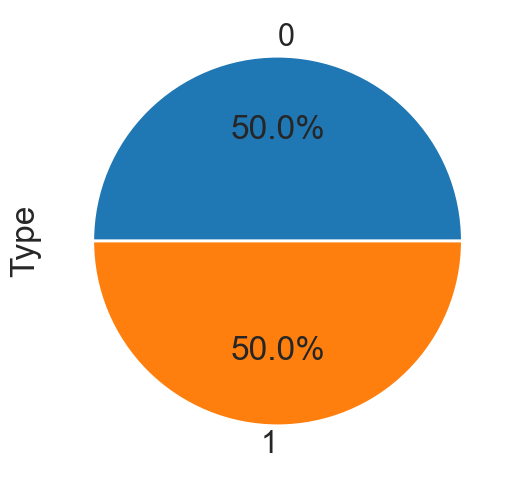

In [1389]:
print(df_upsampled["Attrition_Flag"].value_counts())

df_upsampled.groupby('Attrition_Flag').size().plot(kind='pie',
                                       y = "Attrition_Flag",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [1390]:
df_upsampled.describe()

Customer_Age  Dependent_count  Months_on_book  \
count  17000.000000     17000.000000    17000.000000   
mean      46.271294         2.220765       35.856235   
std        7.338467         1.211560        7.371276   
min       26.000000         0.000000       13.000000   
25%       41.000000         1.000000       32.000000   
50%       46.000000         2.000000       36.000000   
75%       51.000000         3.000000       40.000000   
max       73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              17000.000000            17000.000000   
mean                   3.452824                2.360294   
std                    1.506660                0.910366   
min                    1.000000                0.000000   
25%                    2.000000                2.000000   
50%                    3.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count           17000.000000  17000.000000         17000.000000   
mean                2.525353   8402.713796           952.554471   
std                 1.029624   9093.883157           885.483077   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2395.000000             0.000000   
50%                 3.000000   4332.580047           928.000000   
75%                 3.000000  10410.250000          1686.250000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count     17000.000000          17000.000000     17000.000000    17000.000000   
mean       7450.075459              0.731899      3871.525882       56.681529   
std        9102.023938              0.210232      3063.080767       22.415308   
min           3.000000              0.000000       510.000000       10.000000   
25%        1438.300000              0.604654      2021.000000       40.000000   
50%        3453.444526              0.721676      2657.000000       51.000000   
75%        9549.893091              0.847534      4578.000000       73.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio        Gender  \
count         17000.000000           17000.000000  17000.000000   
mean              0.648346               0.229053      0.378471   
std               0.233667               0.277267      0.485020   
min               0.000000               0.000000      0.000000   
25%               0.498746               0.000000      0.000000   
50%               0.639000               0.094011      0.000000   
75%               0.775369               0.417694      1.000000   
max               3.714000               0.999000      1.000000   

       Education_Level  Marital_Status  Income_Category  Card_Category  \
count     17000.000000    17000.000000     17000.000000   17000.000000   
mean          2.945294        1.348294         2.749824       0.159471   
std           1.713820        0.703991         1.436521       0.624644   
min           0.000000        0.000000         0.000000       0.000000   
25%           2.000000        1.000000         2.000000       0.000000   
50%           3.000000        1.000000         3.000000       0.000000   
75%           4.000000        2.000000         4.000000       0.000000   
max           6.000000        3.000000         5.000000       3.000000   

       Attrition_Flag  
count    17000.000000  
mean         0.500000  
std          0.500015  
min          0.000000  
25%          0.000000  
50%          0.500000  
75%          1.000000  
max          1.000000

In [1391]:
df.describe()

Customer_Age  Dependent_count  Months_on_book  \
count  10127.000000     10127.000000    10127.000000   
mean      46.325960         2.346203       35.928409   
std        8.016814         1.298908        7.986416   
min       26.000000         0.000000       13.000000   
25%       41.000000         1.000000       31.000000   
50%       46.000000         2.000000       36.000000   
75%       52.000000         3.000000       40.000000   
max       73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count           10127.000000  10127.000000         10127.000000   
mean                2.455317   8631.953698          1162.814061   
std                 1.106225   9088.776650           814.987335   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2555.000000           359.000000   
50%                 2.000000   4549.000000          1276.000000   
75%                 3.000000  11067.500000          1784.000000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count     10127.000000          10127.000000     10127.000000    10127.000000   
mean       7469.139637              0.759941      4404.086304       64.858695   
std        9090.685324              0.219207      3397.129254       23.472570   
min           3.000000              0.000000       510.000000       10.000000   
25%        1324.500000              0.631000      2155.500000       45.000000   
50%        3474.000000              0.736000      3899.000000       67.000000   
75%        9859.000000              0.859000      4741.000000       81.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  Attrition_Flag  
count         10127.000000           10127.000000    10127.000000  
mean              0.712222               0.274894        0.839340  
std               0.238086               0.275691        0.367235  
min               0.000000               0.000000        0.000000  
25%               0.582000               0.023000        1.000000  
50%               0.702000               0.176000        1.000000  
75%               0.818000               0.503000        1.000000  
max               3.714000               0.999000        1.000000

### **Data Transformation**

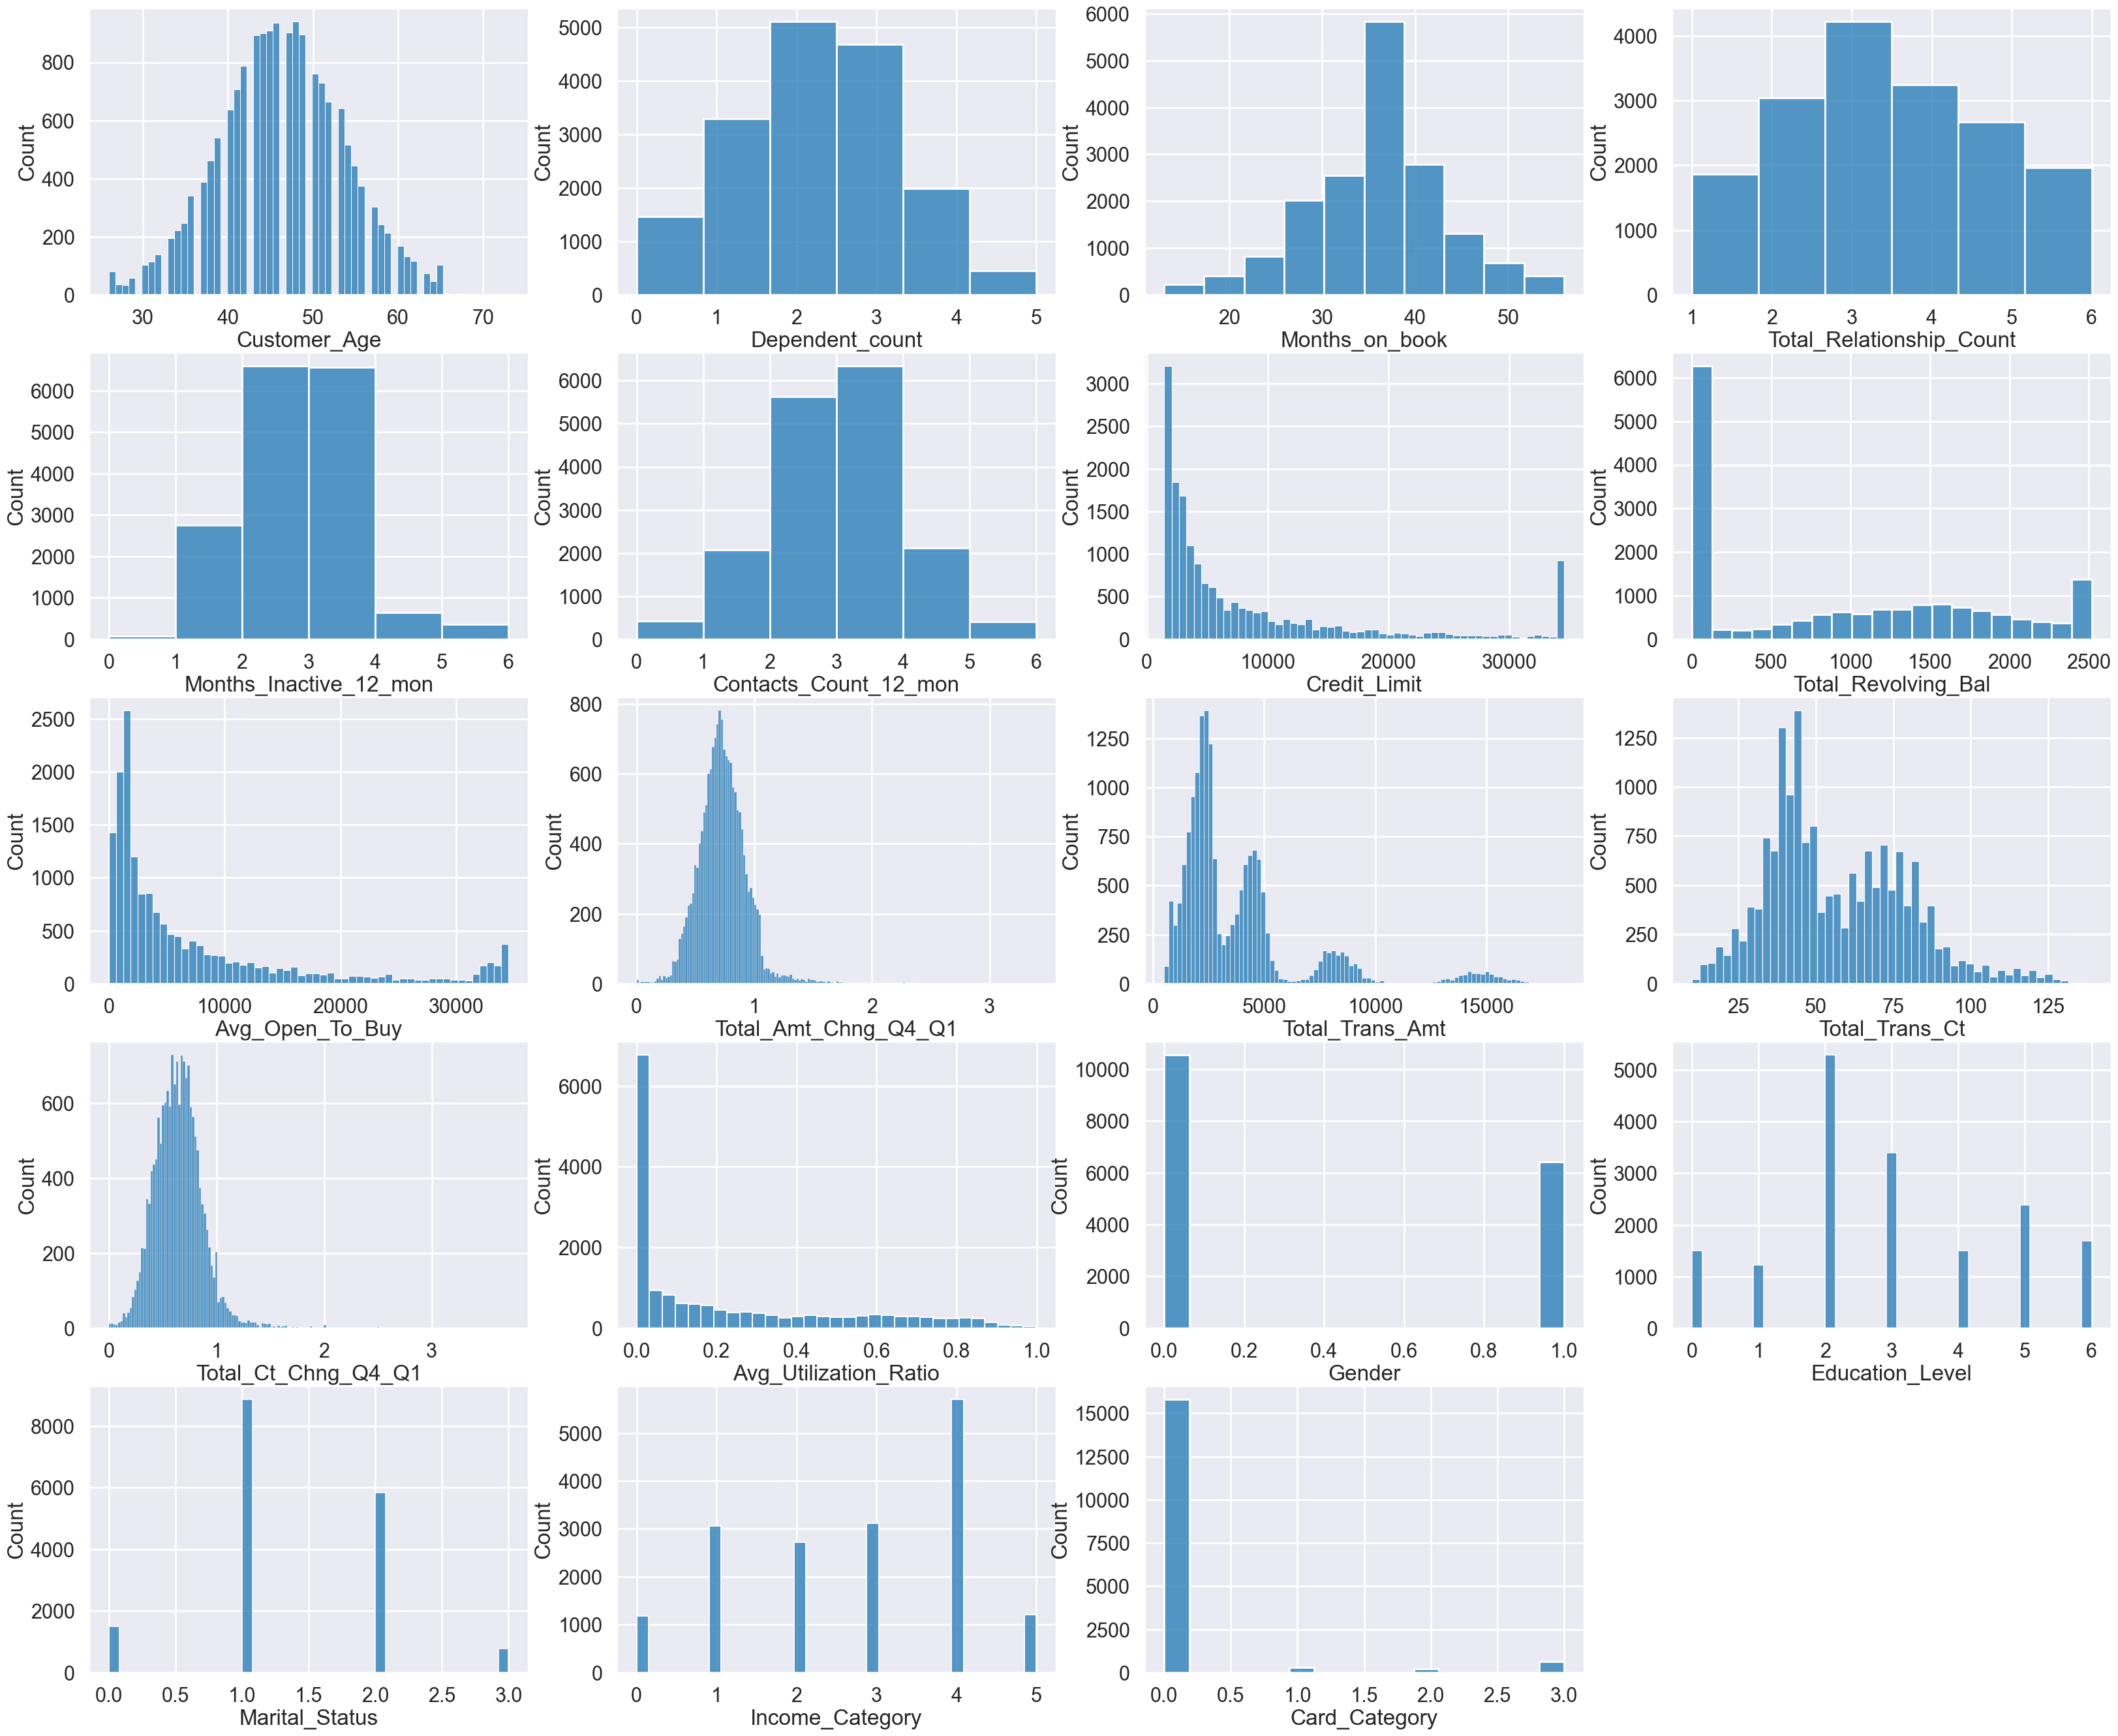

In [1392]:
# plot numerical data
plt.figure(figsize=(40,40))

for idx, col in enumerate(df_upsampled.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(6,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(df_upsampled[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(df_upsampled[col],bins=10)
        else:
            sns.histplot(df_upsampled[col])

In [1393]:
df_upsampled.columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category', 'Attrition_Flag'],
      dtype='object')

In [1394]:
log_var = ['Credit_Limit','Avg_Open_To_Buy',
           'Total_Amt_Chng_Q4_Q1','Total_Ct_Chng_Q4_Q1']

for idx,col in enumerate(log_var):
    df_upsampled[col] = np.log10(df_upsampled[col]+1)

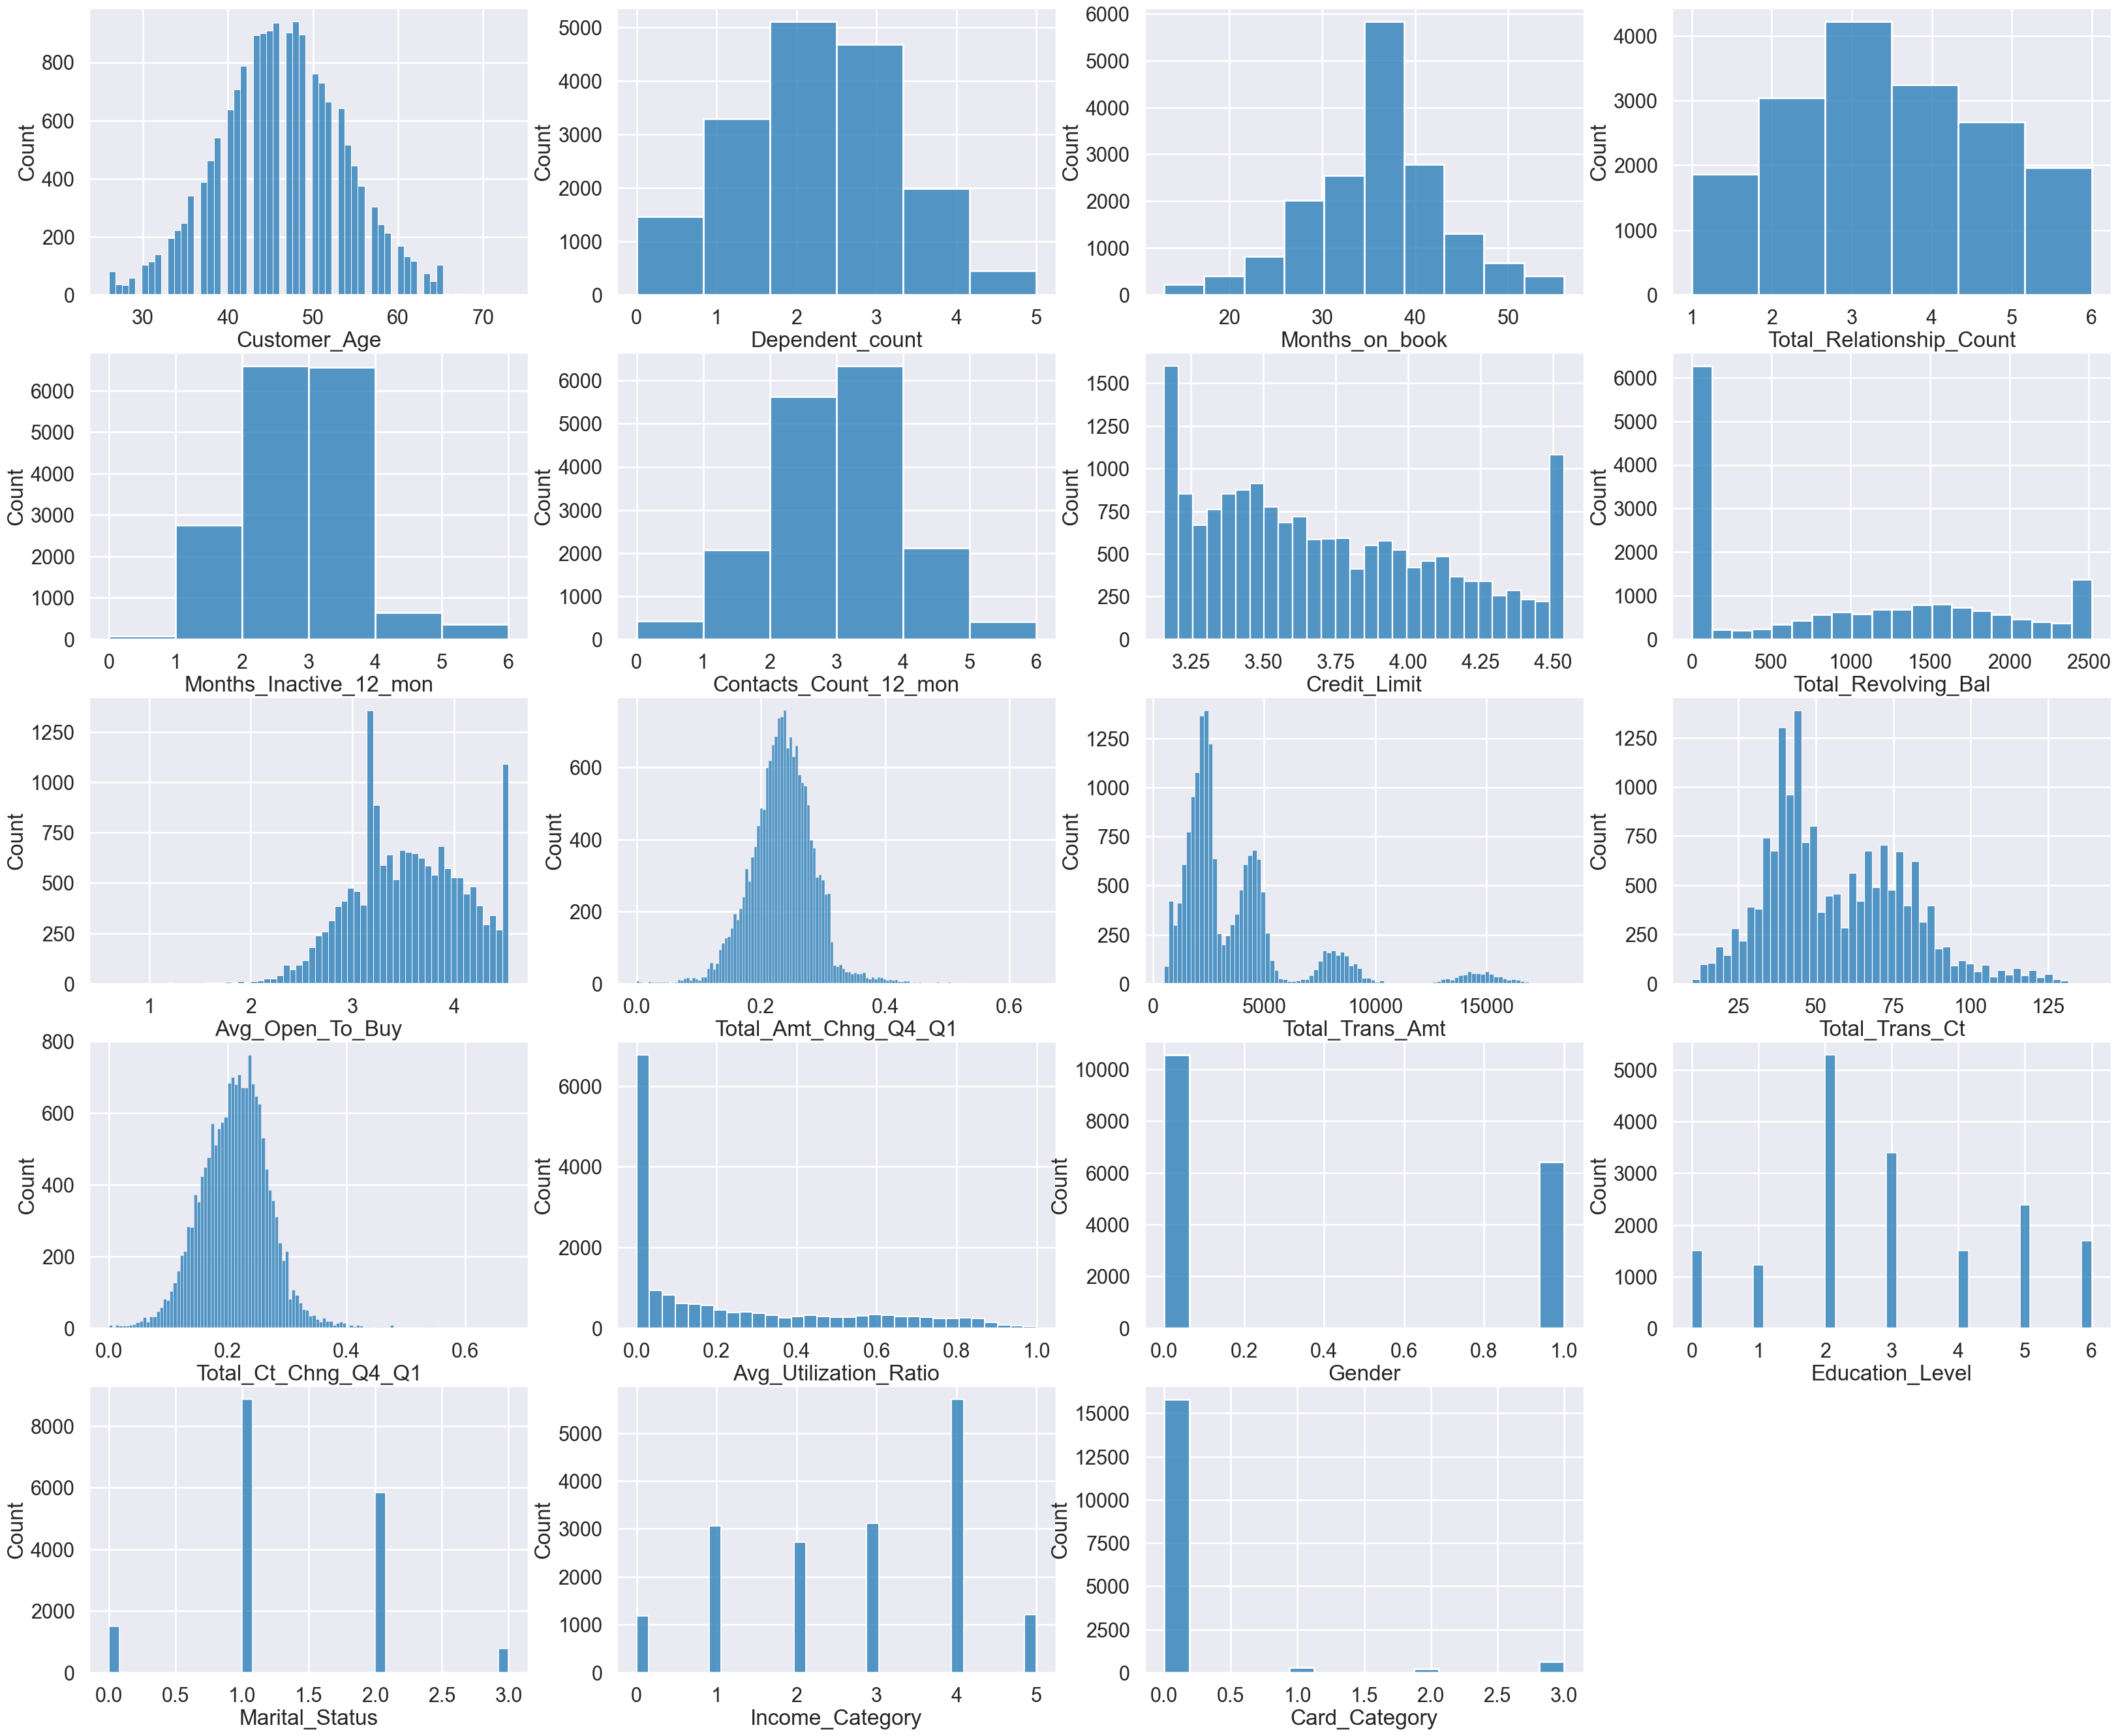

In [1395]:
# plot numerical data
plt.figure(figsize=(40,40))

for idx, col in enumerate(df_upsampled.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(6,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(df_upsampled[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(df_upsampled[col],bins=10)
        else:
            sns.histplot(df_upsampled[col])

### **Clear outlier**

#### **Strip Plot**

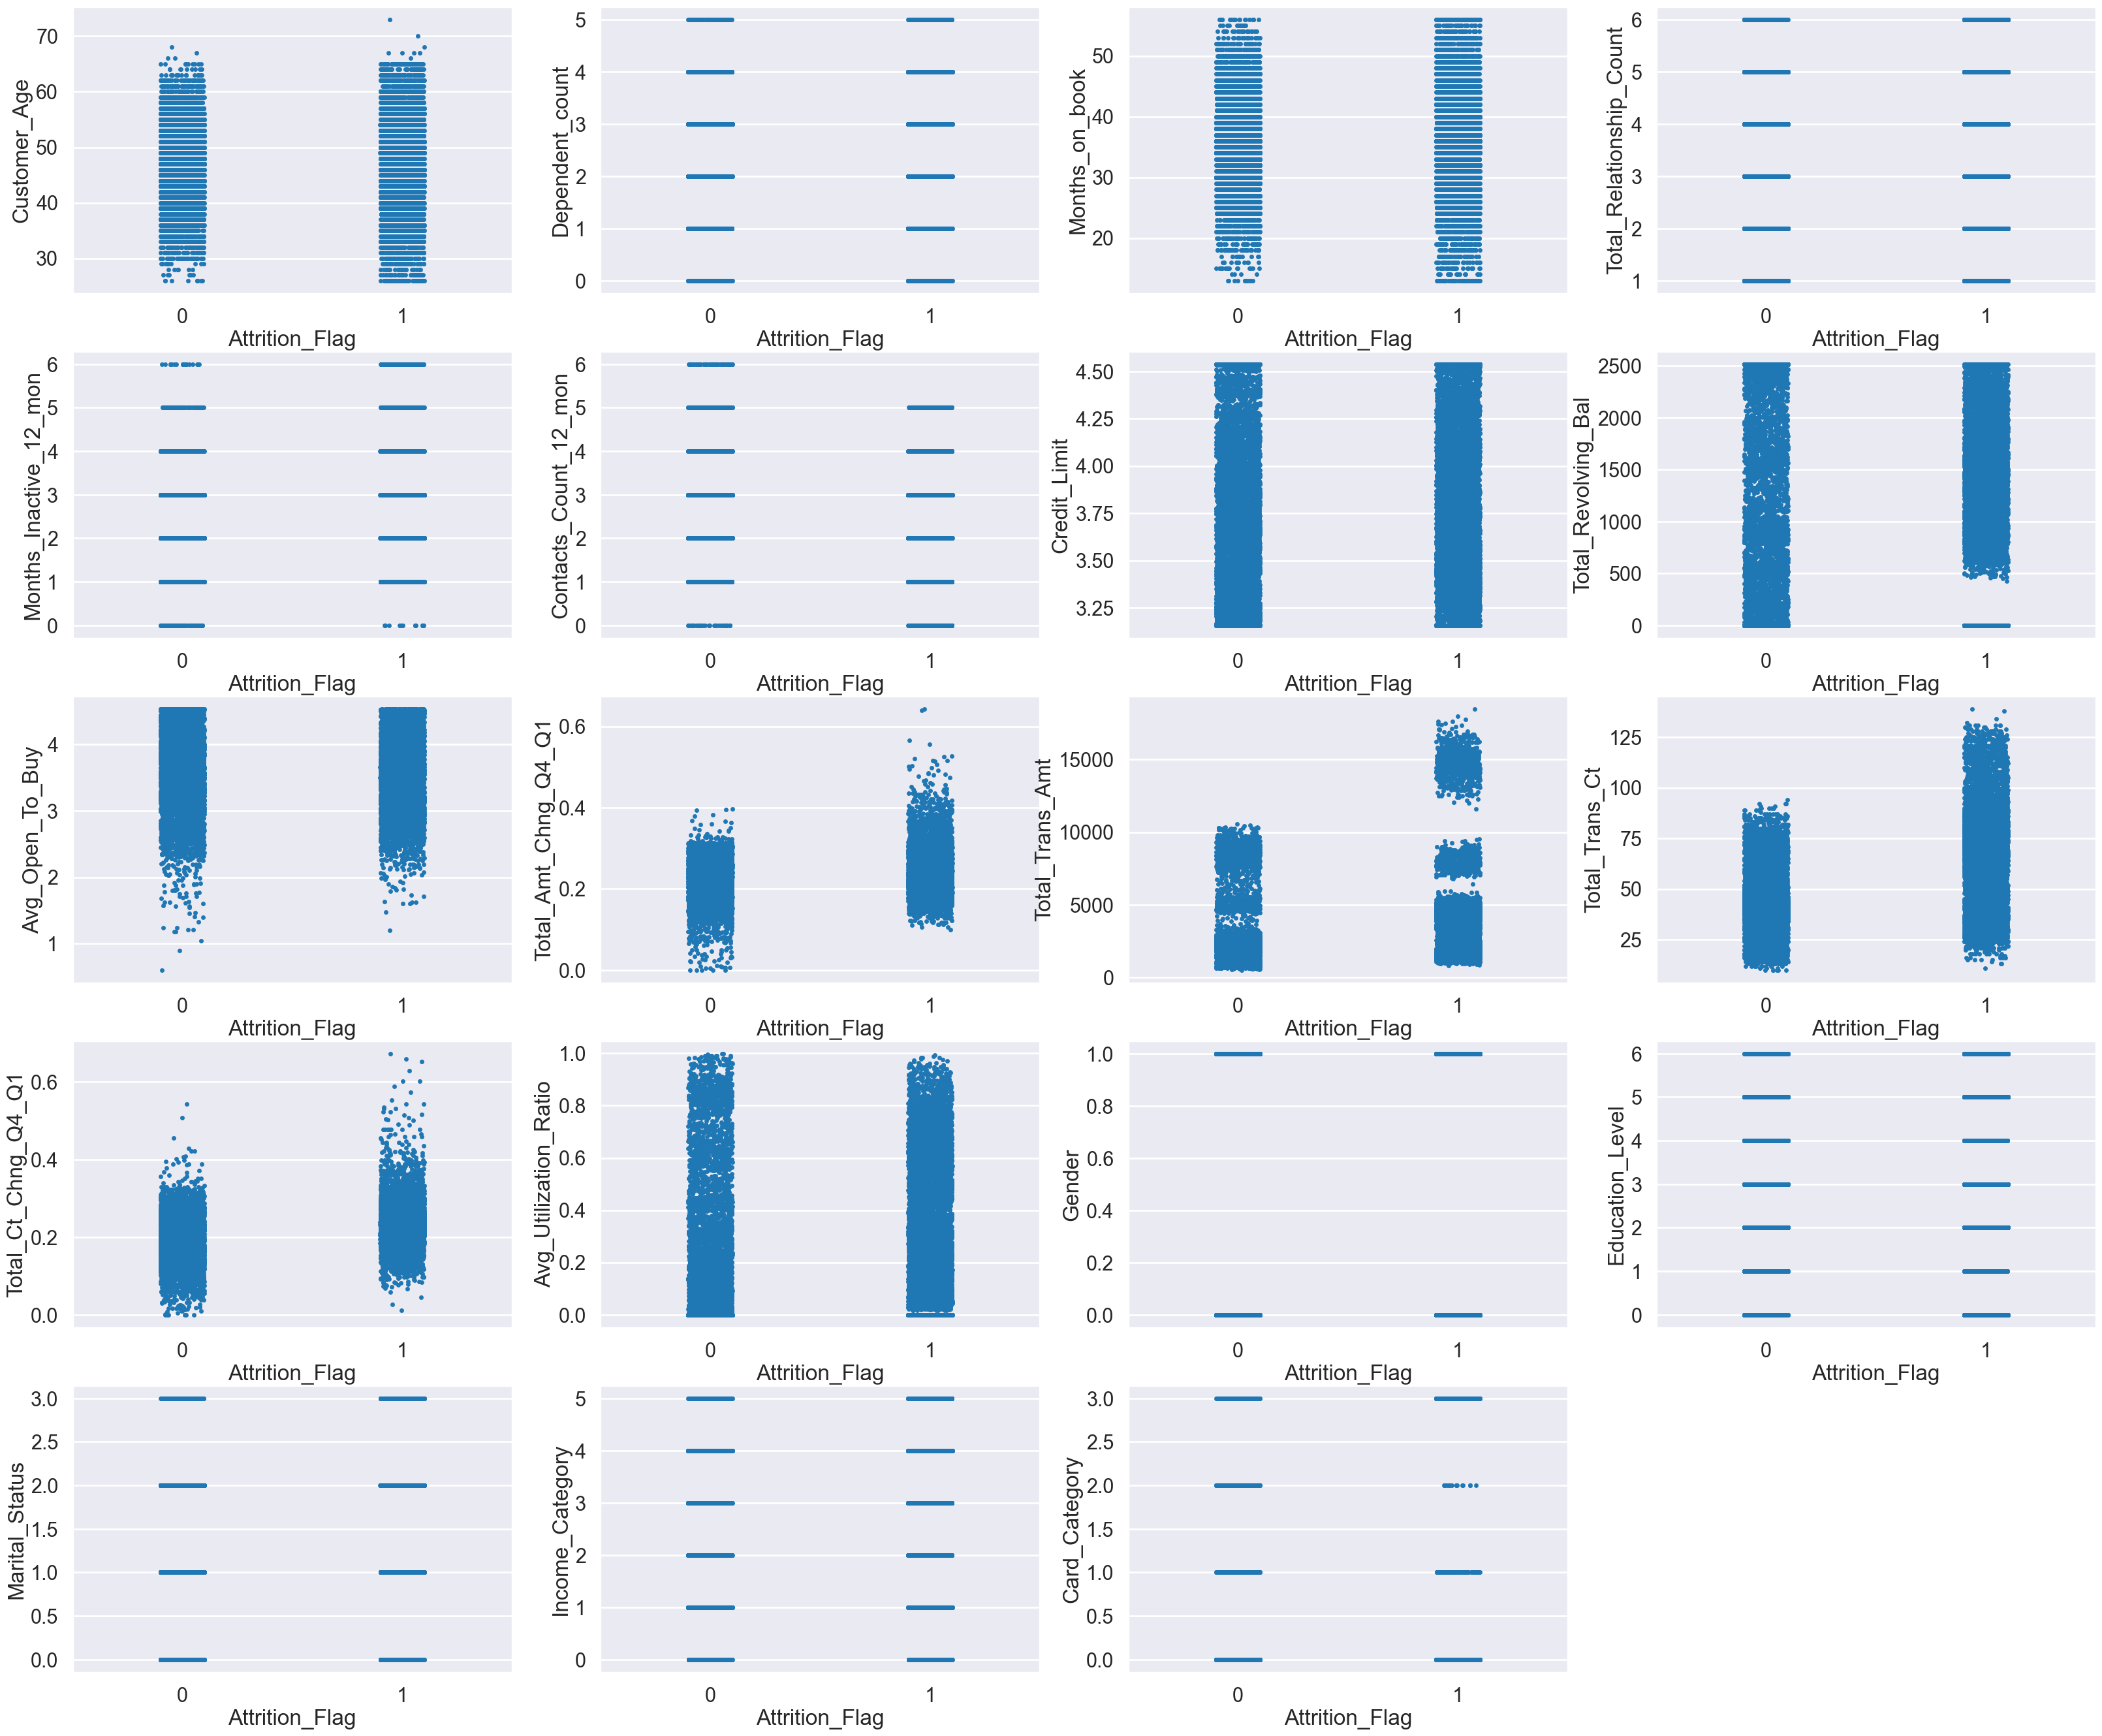

In [1396]:
plt.figure(figsize=(40,40))
for idx, col in enumerate(df_upsampled.columns):
    if col not in ["Attrition_Flag"]:
        plt.subplot(6,4,idx+1)
        sns.stripplot(x="Attrition_Flag", y=col, data=df_upsampled)

#### **Remove Outliers**

In [1397]:
df_upsampled.columns

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category', 'Attrition_Flag'],
      dtype='object')

In [1398]:
print('Before remove outlier, the shape of df_upsampled: {}'.format(df_upsampled.shape))

df_upsampled = df_upsampled.drop(df_upsampled[df_upsampled['Avg_Open_To_Buy'] <= 2.0].index & df_upsampled[df_upsampled['Attrition_Flag'] == 0].index)
df_upsampled = df_upsampled.drop(df_upsampled[df_upsampled['Avg_Open_To_Buy'] <= 2.0].index & df_upsampled[df_upsampled['Attrition_Flag'] == 1].index)
print(df_upsampled.shape)

# df_upsampled = df_upsampled.drop(df_upsampled[df_upsampled['Total_Amt_Chng_Q4_Q1'] >= 0.39].index & df_upsampled[df_upsampled['Attrition_Flag'] == 0].index)
# df_upsampled = df_upsampled.drop(df_upsampled[df_upsampled['Total_Amt_Chng_Q4_Q1'] >= 0.5].index & df_upsampled[df_upsampled['Attrition_Flag'] == 1].index)
# print(df_upsampled.shape)

df_upsampled = df_upsampled.drop(df_upsampled[df_upsampled['Total_Trans_Amt'] >= 16000].index & df_upsampled[df_upsampled['Attrition_Flag'] == 1].index)
print(df_upsampled.shape)

df_upsampled = df_upsampled.drop(df_upsampled[df_upsampled['Total_Trans_Ct'] >= 127].index & df_upsampled[df_upsampled['Attrition_Flag'] == 1].index)
print(df_upsampled.shape)

# df_upsampled = df_upsampled.drop(df_upsampled[df_upsampled['Total_Ct_Chng_Q4_Q1'] >= 0.5].index & df_upsampled[df_upsampled['Attrition_Flag'] == 0].index)
# df_upsampled = df_upsampled.drop(df_upsampled[df_upsampled['Total_Ct_Chng_Q4_Q1'] <= 0.0].index & df_upsampled[df_upsampled['Attrition_Flag'] == 0].index)
# print(df_upsampled.shape)

# df_upsampled = df_upsampled.drop(df_upsampled[df_upsampled['Total_Ct_Chng_Q4_Q1'] >= 0.55].index & df_upsampled[df_upsampled['Attrition_Flag'] == 1].index)
# df_upsampled = df_upsampled.drop(df_upsampled[df_upsampled['Total_Ct_Chng_Q4_Q1'] <= 0.05].index & df_upsampled[df_upsampled['Attrition_Flag'] == 1].index)
# print(df_upsampled.shape)

df_upsampled = IQRdrop(df_upsampled, 'Customer_Age')
print(df_upsampled.shape)

df_upsampled = IQRdrop(df_upsampled, 'Total_Ct_Chng_Q4_Q1')
print(df_upsampled.shape)

df_upsampled = IQRdrop(df_upsampled, 'Total_Amt_Chng_Q4_Q1')
print(df_upsampled.shape)

Before remove outlier, the shape of df_upsampled: (17000, 20)
(16932, 20)
(16843, 20)
(16806, 20)
(16797, 20)
(16467, 20)
(16139, 20)


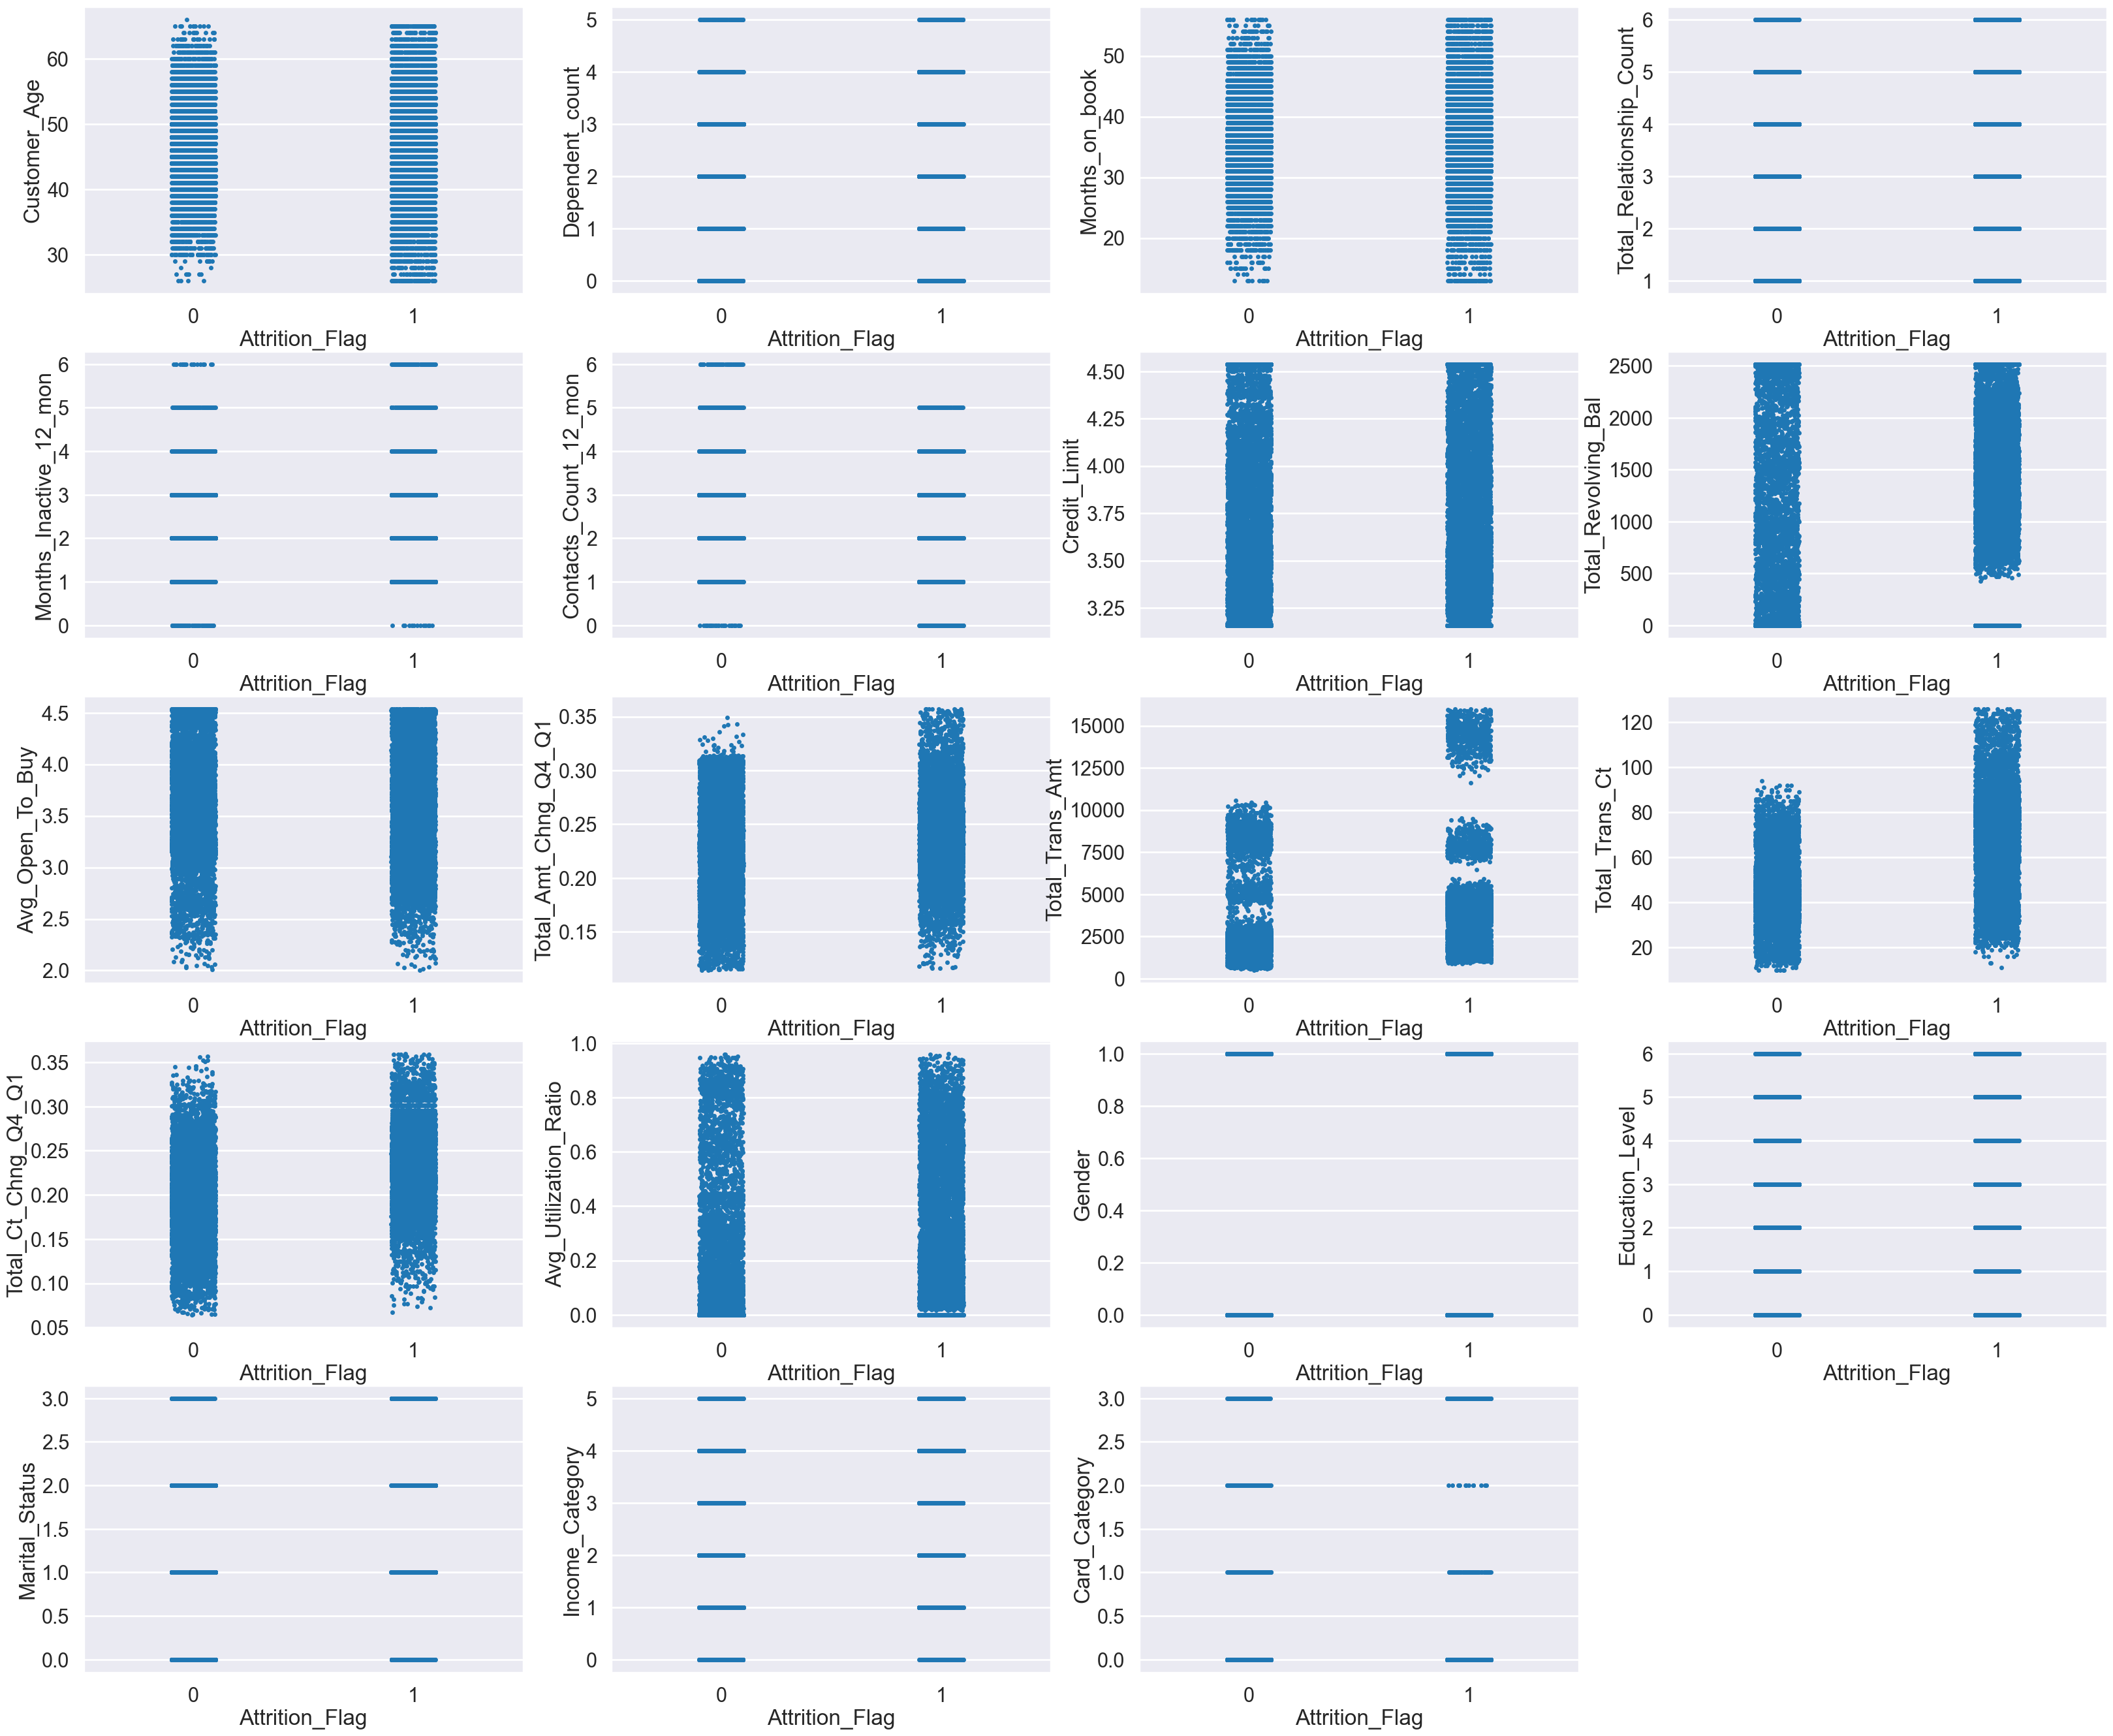

In [1399]:
plt.figure(figsize=(40,40))
for idx, col in enumerate(df_upsampled.columns):
    if col not in ["Attrition_Flag"]:
        plt.subplot(6,4,idx+1)
        sns.stripplot(x="Attrition_Flag", y=col, data=df_upsampled)

### **Feature Scaling (Numerical)**

In [1400]:
robust_scaler = RobustScaler()
min_max_scaler = MinMaxScaler()

for idx in df_upsampled.columns:
    if idx not in ['Attrition_Flag']:
        df_upsampled[idx]=min_max_scaler.fit_transform(df_upsampled[idx].values.reshape(-1,1))

In [1401]:
df_upsampled.describe()

Customer_Age  Dependent_count  Months_on_book  \
count  16139.000000     16139.000000    16139.000000   
mean       0.033088         0.111655       -0.015266   
std        0.806951         0.605608        0.913716   
min       -2.222222        -1.000000       -2.875000   
25%       -0.444444        -0.500000       -0.500000   
50%        0.000000         0.000000        0.000000   
75%        0.555556         0.500000        0.500000   
max        2.222222         1.500000        2.500000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              16139.000000            16139.000000   
mean                   0.150732                0.362538   
std                    0.503098                0.909520   
min                   -0.666667               -2.000000   
25%                   -0.333333                0.000000   
50%                    0.000000                0.000000   
75%                    0.666667                1.000000   
max                    1.000000                4.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count           16139.000000  16139.000000         16139.000000   
mean               -0.476609      0.126358             0.020872   
std                 1.030274      0.649406             0.530347   
min                -3.000000     -0.752138            -0.543054   
25%                -1.000000     -0.406234            -0.543054   
50%                 0.000000      0.000000             0.000000   
75%                 0.000000      0.593766             0.456946   
max                 3.000000      1.424899             0.967297   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count     16139.000000          16139.000000     16139.000000    16139.000000   
mean          0.025794             -0.017345         0.460213        0.150676   
std           0.670777              0.736169         1.155676        0.659858   
min          -1.877500             -2.027740        -0.863312       -1.272727   
25%          -0.463674             -0.497851        -0.247623       -0.363636   
50%           0.000000              0.000000         0.000000        0.000000   
75%           0.536326              0.502149         0.752377        0.636364   
max           1.227139              2.050195         5.273376        2.242424   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio        Gender  \
count         16139.000000           16139.000000  16139.000000   
mean             -0.029879               0.325947      0.372948   
std               0.724004               0.663852      0.483603   
min              -2.091012              -0.220314      0.000000   
25%              -0.526123              -0.220314      0.000000   
50%               0.000000               0.000000      0.000000   
75%               0.473877               0.779686      1.000000   
max               2.047649               2.108715      1.000000   

       Education_Level  Marital_Status  Income_Category  Card_Category  \
count     16139.000000    16139.000000     16139.000000   16139.000000   
mean         -0.033707        0.354049        -0.124977       0.158064   
std           0.853944        0.706141         0.717844       0.620816   
min          -1.500000       -1.000000        -1.500000       0.000000   
25%          -0.500000        0.000000        -0.500000       0.000000   
50%           0.000000        0.000000         0.000000       0.000000   
75%           0.500000        1.000000         0.500000       0.000000   
max           1.500000        2.000000         1.000000       3.000000   

       Attrition_Flag  
count    16139.000000  
mean         0.492224  
std          0.499955  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          1.000000  
max          1.000000

In [1402]:
df_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16139 entries, 10 to 16999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              16139 non-null  float64
 1   Dependent_count           16139 non-null  float64
 2   Months_on_book            16139 non-null  float64
 3   Total_Relationship_Count  16139 non-null  float64
 4   Months_Inactive_12_mon    16139 non-null  float64
 5   Contacts_Count_12_mon     16139 non-null  float64
 6   Credit_Limit              16139 non-null  float64
 7   Total_Revolving_Bal       16139 non-null  float64
 8   Avg_Open_To_Buy           16139 non-null  float64
 9   Total_Amt_Chng_Q4_Q1      16139 non-null  float64
 10  Total_Trans_Amt           16139 non-null  float64
 11  Total_Trans_Ct            16139 non-null  float64
 12  Total_Ct_Chng_Q4_Q1       16139 non-null  float64
 13  Avg_Utilization_Ratio     16139 non-null  float64
 14  Gende

<AxesSubplot:>

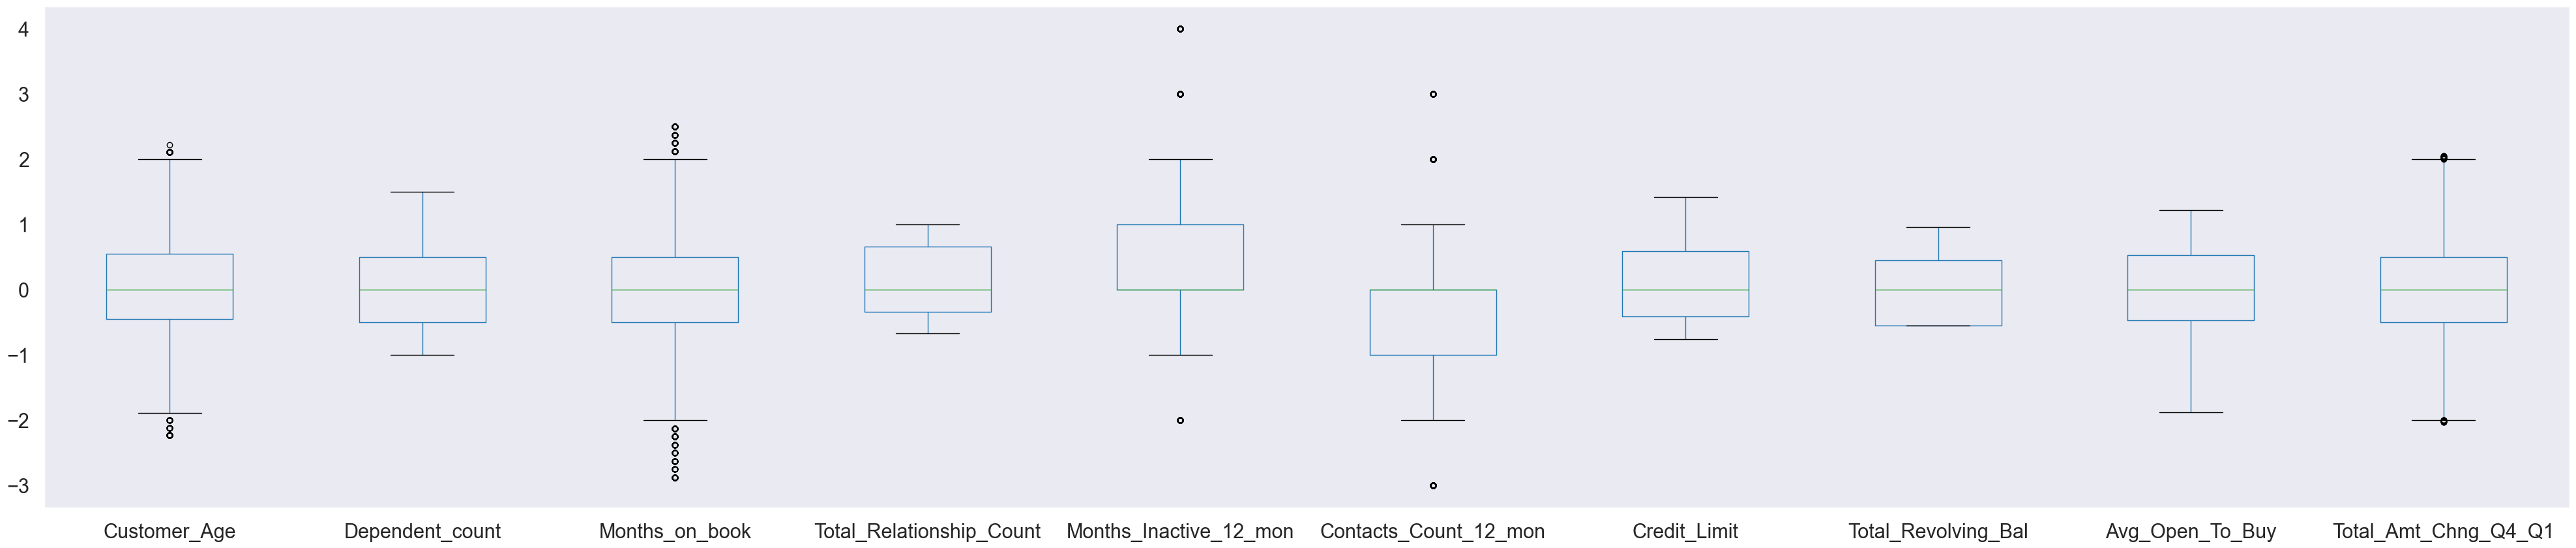

In [1403]:
df_upsampled.boxplot(column=[str(i) for count, i in enumerate(df_upsampled.columns) if i != 'Attrition_Flag' and count < 10], figsize=(50,10), grid=False)

### **Feature Selection**

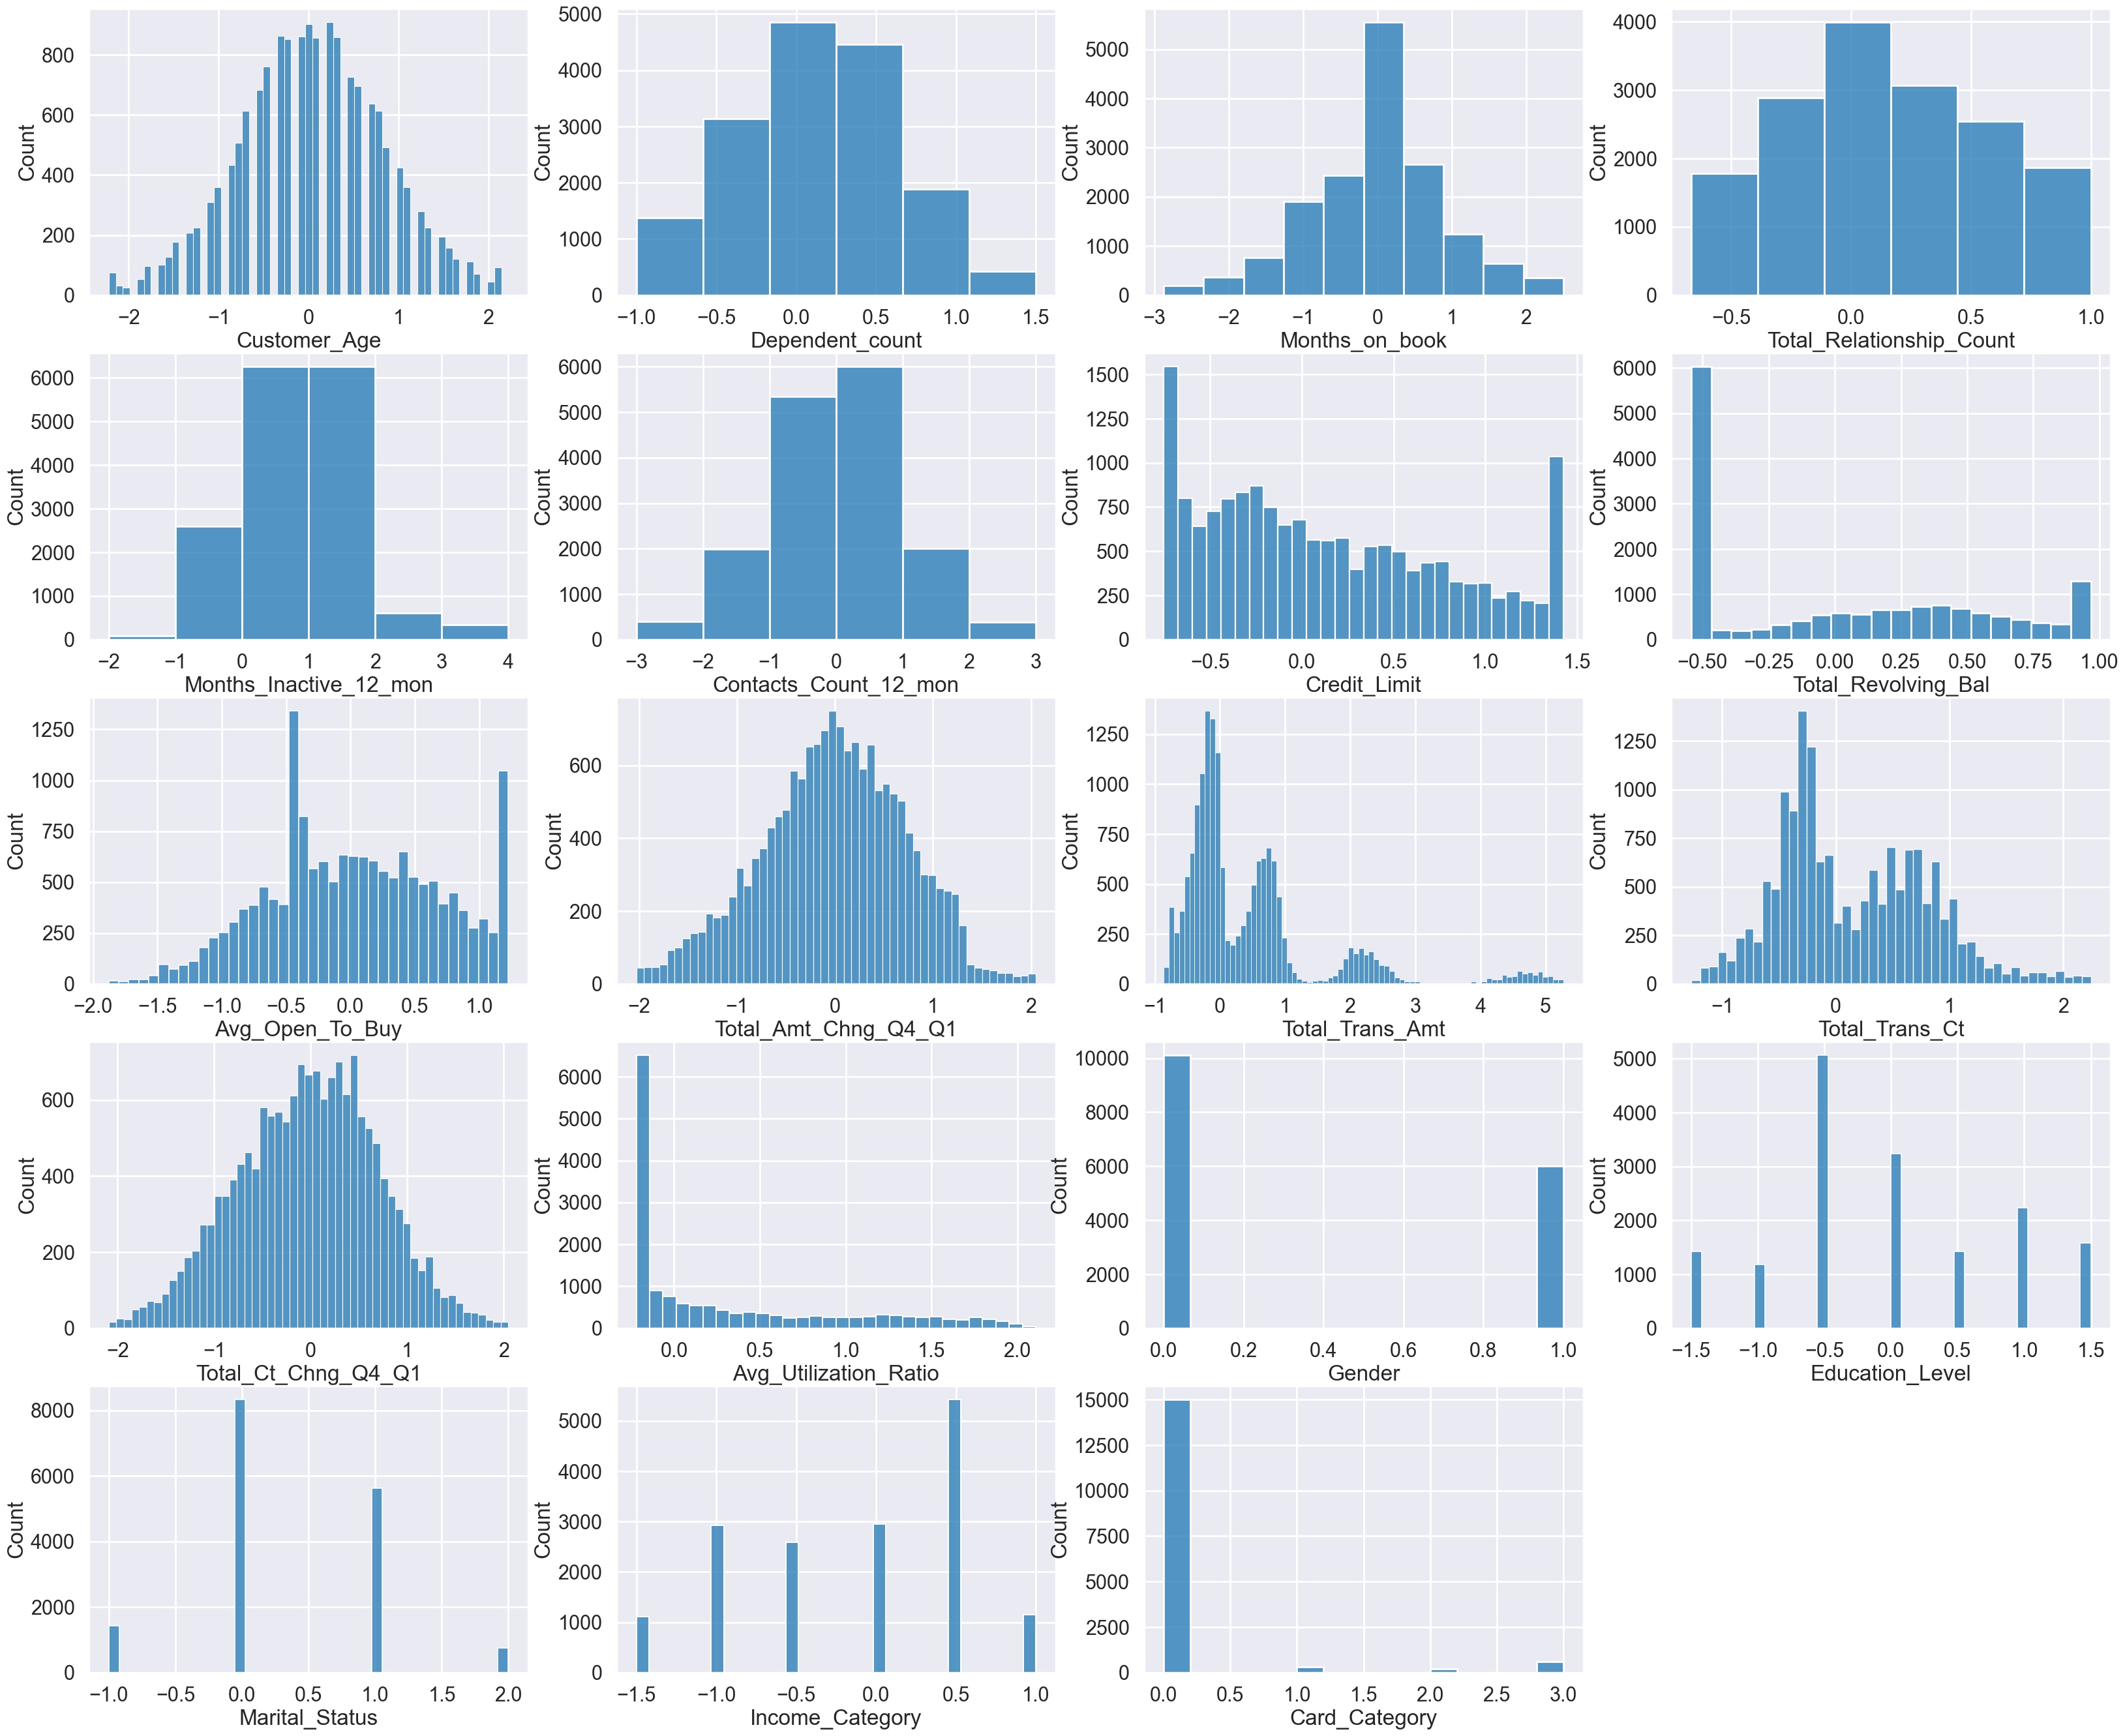

In [1404]:
# plot numerical data
plt.figure(figsize=(40,40))

for idx, col in enumerate(df_upsampled.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(6,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(df_upsampled[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(df_upsampled[col],bins=10)
        else:
            sns.histplot(df_upsampled[col])

In [1405]:
selector = SelectKBest(f_classif, k=9)
x_up = df_upsampled.drop(['Attrition_Flag'], axis = 1)
y_up = df_upsampled['Attrition_Flag']

df_up_anova = selector.fit(x_up, y_up)

col = selector.get_support(indices=True)
df_up_anova = x_up.iloc[:,col]

#### **Concatenate Data**

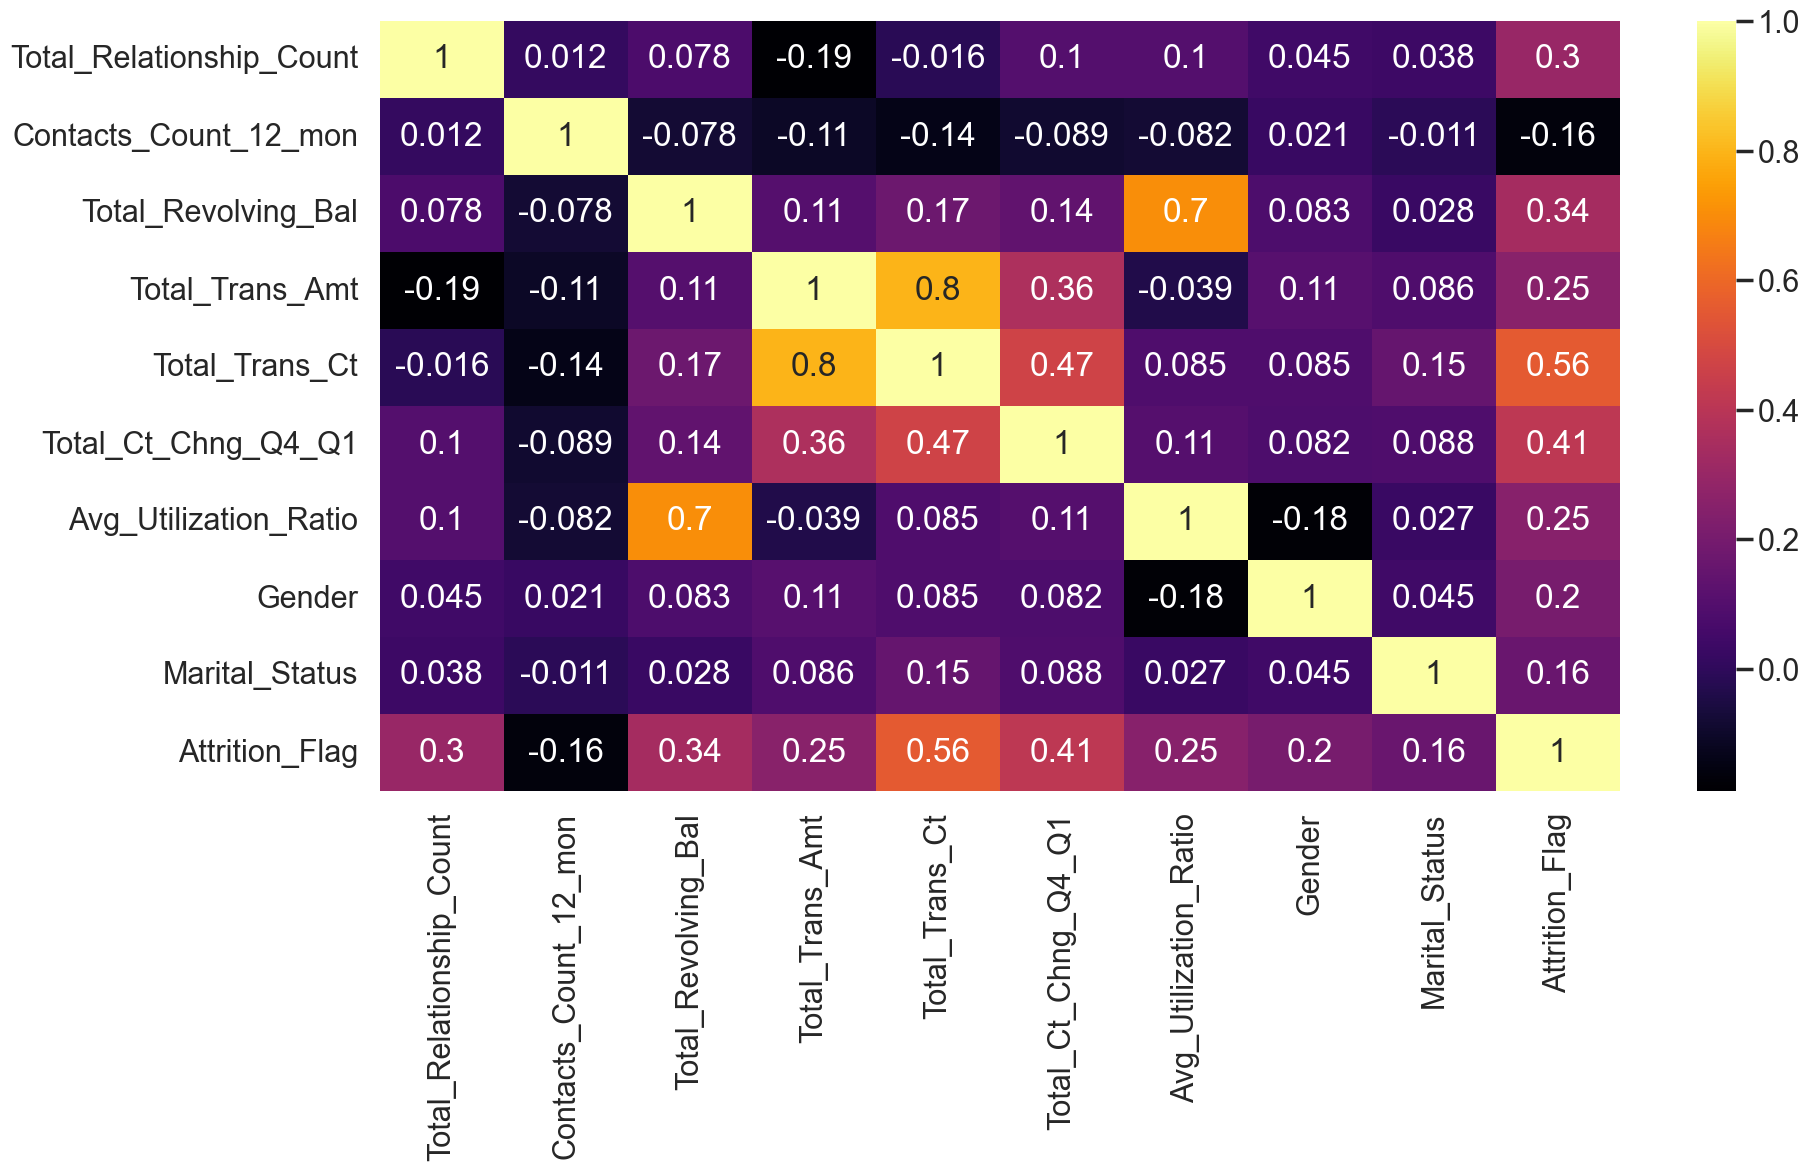

In [1406]:
df_up_anova = pd.concat([df_up_anova, y_up], axis=1)
checkCorrFF(df_up_anova)

In [1407]:
df_up_anova.columns

Index(['Total_Relationship_Count', 'Contacts_Count_12_mon',
       'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Gender',
       'Marital_Status', 'Attrition_Flag'],
      dtype='object')

In [1408]:
# df_up_anova.drop(['Avg_Utilization_Ratio','Total_Trans_Amt','Total_Amt_Chng_Q4_Q1'], axis=1, inplace=True)
df_up_anova.drop(['Avg_Utilization_Ratio','Total_Trans_Amt'], axis=1, inplace=True)

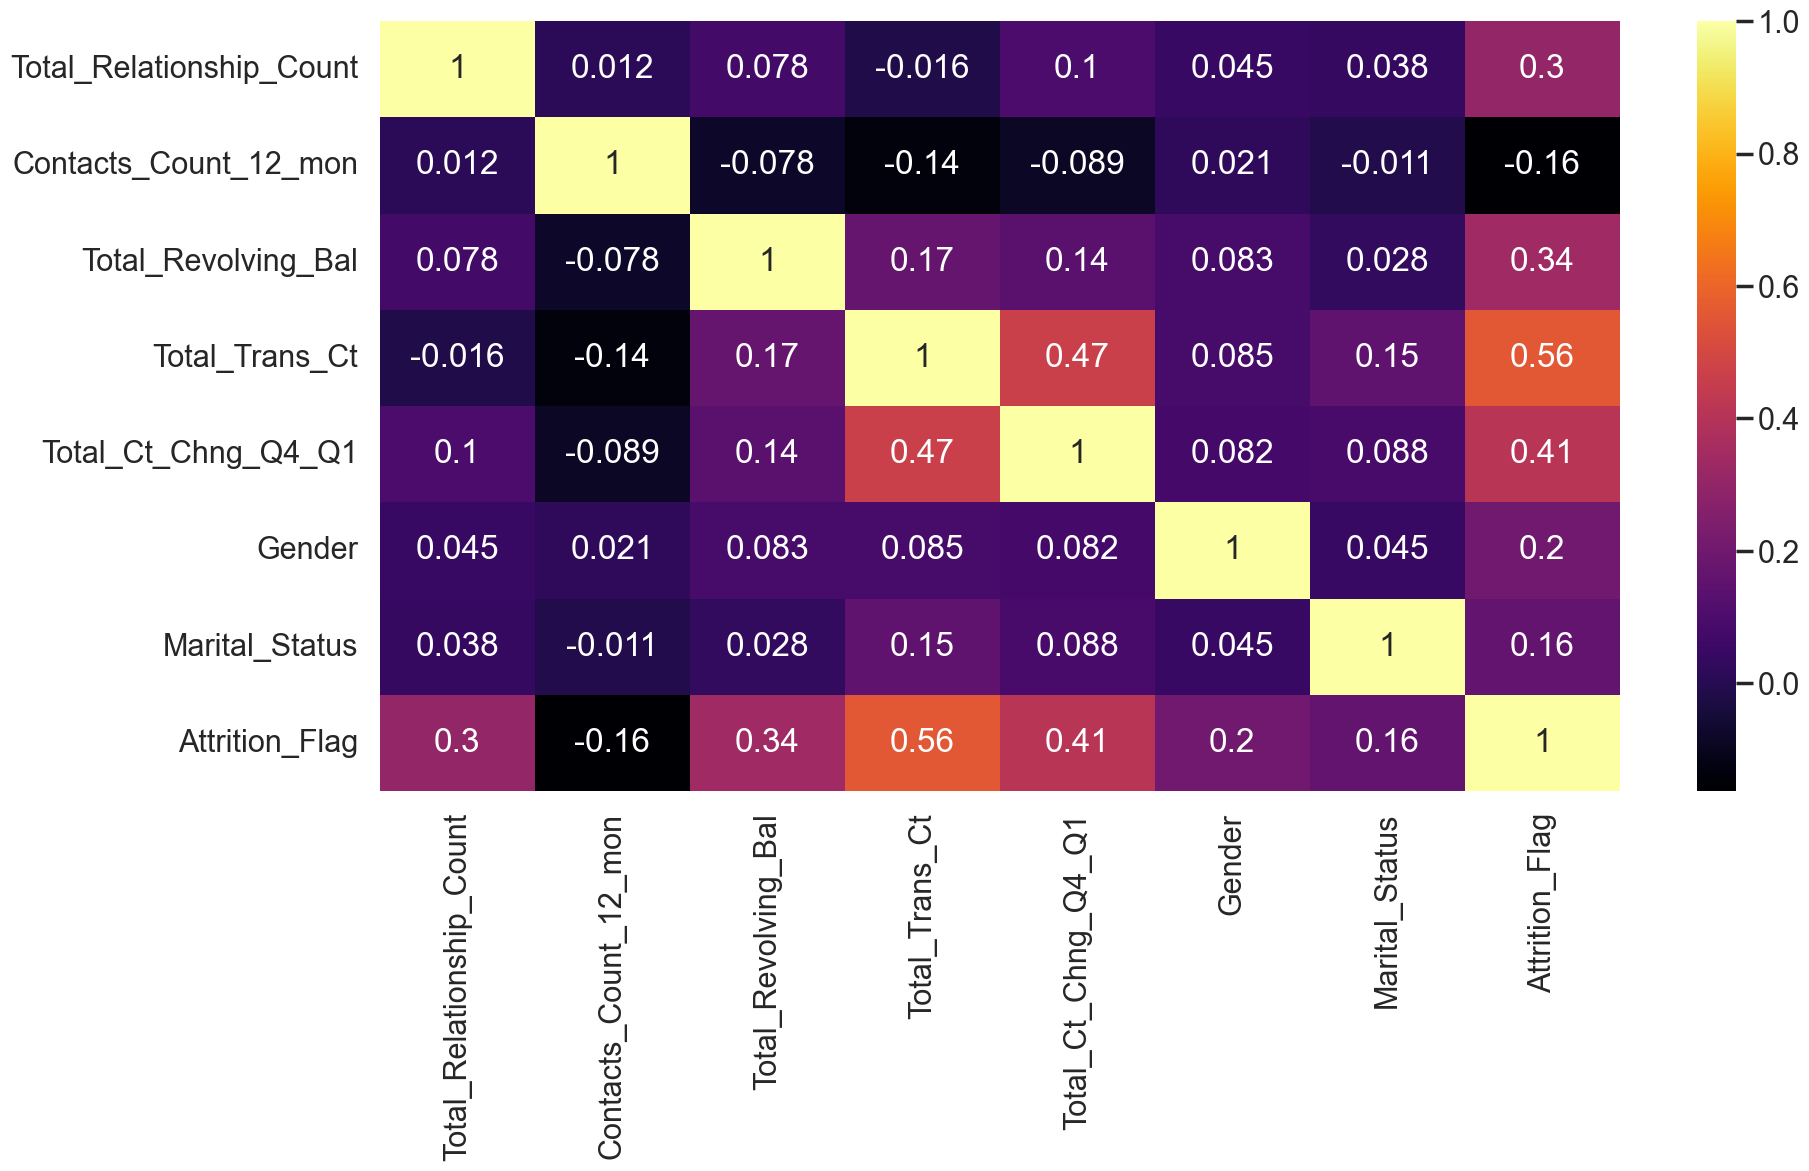

In [1409]:
checkCorrFF(df_up_anova)

## **Model Training**

### **Repeated k-Fold Cross-Validation**

>f1 score 1 mean=0.835957 se=0.002120
>f1 score 2 mean=0.836307 se=0.001808
>f1 score 3 mean=0.836168 se=0.001469
>f1 score 4 mean=0.836287 se=0.001319
>f1 score 5 mean=0.836296 se=0.001220


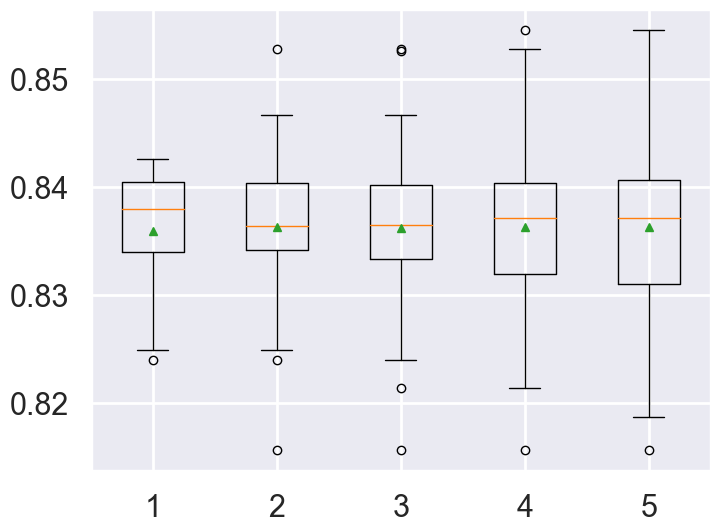

In [1410]:
# create dataset
X_up_anova = df_up_anova.drop(['Attrition_Flag'], axis = 1)
y_up_anova = df_up_anova['Attrition_Flag']

_scoring = ['accuracy', 'precision', 'recall', 'f1']
# configurations to test
repeats = range(1,6)
results_up_anova = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores_up_anova = evaluate_model(X_up_anova, y_up_anova, r,'f1')
	# summarize
	print('>f1 score %d mean=%.6f se=%.6f' % (r, np.mean(scores_up_anova), sem(scores_up_anova)))
	# store
	results_up_anova.append(scores_up_anova)
# plot the results
plt.boxplot(results_up_anova, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

### **GridSearchCV**

In [1411]:
#get the dummy variables for the categorical variables
x_up_anova = df_up_anova.drop(['Attrition_Flag'], axis = 1)
y_up_anova = df_up_anova['Attrition_Flag']

x_up_anova_train,x_up_anova_test,y_up_anova_train,y_up_anova_test = train_test_split(x_up_anova, y_up_anova, test_size = 0.2, random_state = 0)

grid={"C":np.logspace(-6,6,13),
      # "class_weight":[None,"balanced"],
      "penalty":['none', 'elasticnet', 'l1', 'l2'],
      "solver":['newton-cg','lbfgs','liblinear','sag','saga']}
logreg_up_anova=LogisticRegression()
logreg_cv_up_anova=GridSearchCV(logreg_up_anova
                       ,grid
                       ,cv=10
                       ,scoring='f1')
logreg_cv_up_anova.fit(x_up_anova_train,y_up_anova_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv_up_anova.best_params_)
print("f1 :",logreg_cv_up_anova.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
f1 : 0.8379735374090524


In [1412]:
clf_up_anova = LogisticRegression(C=logreg_cv_up_anova.best_params_['C'], penalty=logreg_cv_up_anova.best_params_['penalty'], solver=logreg_cv_up_anova.best_params_['solver'])

clf_up_anova.fit(x_up_anova_train,y_up_anova_train)
print("model score: %.8f" % clf_up_anova.score(x_up_anova_test, y_up_anova_test))

model score: 0.84293680


### **Classification report**

In [1413]:
# Classification report
y_up_anova_pred = clf_up_anova.predict(x_up_anova_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_up_anova_train, y_pred=y_up_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_up_anova_train, y_pred=y_up_anova_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      6521
           1       0.83      0.85      0.84      6390

    accuracy                           0.84     12911
   macro avg       0.84      0.84      0.84     12911
weighted avg       0.84      0.84      0.84     12911

Confusion matrix 
[[5413 1108]
 [ 974 5416]]


In [1414]:
# Classification report
y_up_anova_pred = clf_up_anova.predict(x_up_anova_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_up_anova_test, y_pred=y_up_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_up_anova_test, y_pred=y_up_anova_pred))

Classification report 
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1674
           1       0.83      0.85      0.84      1554

    accuracy                           0.84      3228
   macro avg       0.84      0.84      0.84      3228
weighted avg       0.84      0.84      0.84      3228

Confusion matrix 
[[1400  274]
 [ 233 1321]]


# **Resampling Method 2** : Downsampling
<hr>

## **Data Preprocessing**
### **Resampling**

In [ ]:
Att0_messages = df_LE[df_LE["Attrition_Flag"] == 0]
Att1_messages  = df_LE[df_LE["Attrition_Flag"] == 1]
print(Att0_messages.shape)
print(Att1_messages.shape)

In [ ]:
Att_dwsample = resample(Att1_messages,
             replace=True,
             n_samples=len(Att0_messages),
             random_state=42)

print(Att_dwsample.shape)

In [ ]:
df_dwsampled = pd.concat([Att_dwsample, Att0_messages])

print(df_dwsampled["Attrition_Flag"].value_counts())

df_dwsampled.groupby('Attrition_Flag').size().plot(kind='pie',
                                                y = "Attrition_Flag",
                                                label = "Type",
                                                autopct='%1.1f%%')

In [ ]:
df_dwsampled.describe()

In [ ]:
df.describe()

### **Feature Scaling (Numerical)**

In [ ]:
min_max_scaler = MinMaxScaler()

for idx in df_dwsampled.columns:
    if idx not in ['Attrition_Flag']:
        df_dwsampled[idx]=min_max_scaler.fit_transform(df_dwsampled[idx].values.reshape(-1,1))

In [ ]:
df_dwsampled.describe()

In [ ]:
df_dwsampled.info()

### **Clear outlier**

In [ ]:
# plot numerical data
plt.figure(figsize=(40,40))

for idx, col in enumerate(df_dwsampled.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(6,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(df_dwsampled[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(df_dwsampled[col],bins=10)
        else:
            sns.histplot(df_dwsampled[col])

**Strip Plot**

In [ ]:
plt.figure(figsize=(40,40))
for idx, col in enumerate(df_dwsampled.columns):
    if col not in ["Attrition_Flag"]:
        plt.subplot(6,4,idx+1)
        sns.stripplot(x="Attrition_Flag", y=col, data=df_dwsampled)

**Remove Outliers**

In [ ]:
df_dwsampled = df_dwsampled.drop(df_dwsampled[df_dwsampled['Total_Ct_Chng_Q4_Q1'] >= 0.37].index & df_dwsampled[df_dwsampled['Attrition_Flag'] == 0].index)
df_dwsampled = df_dwsampled.drop(df_dwsampled[df_dwsampled['Total_Ct_Chng_Q4_Q1'] >= 0.6].index & df_dwsampled[df_dwsampled['Attrition_Flag'] == 1].index)
print(df_dwsampled.shape)

df_dwsampled = df_dwsampled.drop(df_dwsampled[df_dwsampled['Total_Amt_Chng_Q4_Q1'] >= 0.425].index & df_dwsampled[df_dwsampled['Attrition_Flag'] == 0].index)
df_dwsampled = df_dwsampled.drop(df_dwsampled[df_dwsampled['Total_Amt_Chng_Q4_Q1'] >= 0.8].index & df_dwsampled[df_dwsampled['Attrition_Flag'] == 1].index)
print(df_dwsampled.shape)

df_dwsampled = IQRdrop(df_dwsampled, 'Customer_Age')

In [ ]:
plt.figure(figsize=(40,40))
for idx, col in enumerate(df_dwsampled.columns):
    if col not in ["Attrition_Flag"]:
        plt.subplot(6,4,idx+1)
        sns.stripplot(x="Attrition_Flag", y=col, data=df_dwsampled)

### **Feature Selection**

In [ ]:
selector_dw_anova = SelectKBest(f_classif, k=9)
x_dw = df_dwsampled.drop(['Attrition_Flag'], axis = 1)
y_dw = df_dwsampled['Attrition_Flag']

df_dw_anova = selector_dw_anova.fit(x_dw, y_dw)

col_dw_anova = selector_dw_anova.get_support(indices=True)
df_dw_anova = x_dw.iloc[:,col_dw_anova]

#### **Concatenate Data**

In [ ]:
df_dw_anova = pd.concat([df_dw_anova, y_dw], axis=1)
checkCorrFF(df_dw_anova)

In [ ]:
df_dw_anova.columns

In [ ]:
df_dw_anova.drop(['Avg_Utilization_Ratio','Total_Trans_Amt','Total_Amt_Chng_Q4_Q1'], axis=1, inplace=True)

In [ ]:
checkCorrFF(df_dw_anova)

## **Model Training**

### **Repeated k-Fold Cross-Validation**

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from scipy.stats import sem

# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats,scores):
	# prepare the cross-validation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
	# create model
	model = LogisticRegression()
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=scores, cv=cv, n_jobs=-1)
	return scores

# create dataset
X_dw_anova = df_dw_anova.drop(['Attrition_Flag'], axis = 1)
y_dw_anova = df_dw_anova['Attrition_Flag']

_scoring = ['accuracy', 'precision', 'recall', 'f1']
# configurations to test
repeats = range(1,6)
results_dw_anova = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores_dw_anova = evaluate_model(X_dw_anova, y_dw_anova, r,'f1')
	# summarize
	print('>f1 score %d mean=%.4f se=%.3f' % (r, np.mean(scores_dw_anova), sem(scores_dw_anova)))
	# store
	results_dw_anova.append(scores_dw_anova)
# plot the results
plt.boxplot(results_dw_anova, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

### **GridSearchCV**

In [ ]:
from sklearn.model_selection import GridSearchCV

#get the dummy variables for the categorical variables
x_dw_anova = df_dw_anova.drop(['Attrition_Flag'], axis = 1)
y_dw_anova = df_dw_anova['Attrition_Flag']

x_dw_anova_train,x_dw_anova_test,y_dw_anova_train,y_dw_anova_test = train_test_split(x_dw_anova, y_dw_anova, test_size = 0.2, random_state = 0)

grid={"C":np.logspace(-6,6,13),
      # "class_weight":[None,"balanced"],
      "penalty":['none', 'elasticnet', 'l1', 'l2'],
      "solver":['newton-cg','lbfgs','liblinear','sag','saga']}
logreg_dw_anova=LogisticRegression()
logreg_cv_dw_anova=GridSearchCV(logreg_dw_anova
                              ,grid
                              ,cv=10
                              ,scoring='f1')
logreg_cv_dw_anova.fit(x_dw_anova_train,y_dw_anova_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv_dw_anova.best_params_)
print("f1 :",logreg_cv_dw_anova.best_score_)

In [ ]:
clf_dw_anova = LogisticRegression(C=logreg_cv_dw_anova.best_params_['C']
                                  , penalty=logreg_cv_dw_anova.best_params_['penalty']
                                  , solver=logreg_cv_dw_anova.best_params_['solver'])

clf_dw_anova.fit(x_dw_anova_train,y_dw_anova_train)
print("model score: %.8f" % clf_dw_anova.score(x_dw_anova_test, y_dw_anova_test))

### **Classification report**

In [ ]:
# Classification report
y_dw_anova_pred = clf_dw_anova.predict(x_dw_anova_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_dw_anova_train, y_pred=y_dw_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_dw_anova_train, y_pred=y_dw_anova_pred))

In [ ]:
# Classification report
y_dw_anova_pred = clf_dw_anova.predict(x_dw_anova_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_dw_anova_test, y_pred=y_dw_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_dw_anova_test, y_pred=y_dw_anova_pred))

# **Resampling Method 3** : Tomek Links
<hr>

## **Data Preprocessing**

### **Resampling**

In [ ]:
undersample = TomekLinks()

# transform the dataset
dfX = df_LE.drop(['Attrition_Flag'], axis=1)
dfY = df_LE['Attrition_Flag']
X, y = undersample.fit_resample(dfX, dfY)
dfTomek = pd.concat([X, y], axis=1)

dfTomek.groupby('Attrition_Flag').size().plot(kind='pie',
                                        y = "Attrition_Flag",
                                        label = "Type",
                                        autopct='%1.1f%%')

In [ ]:
print(dfTomek["Attrition_Flag"].value_counts())

dfTomek.groupby('Attrition_Flag').size().plot(kind='pie',
                                       y = "Attrition_Flag",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [ ]:
dfTomek.describe()

In [ ]:
df.describe()

### **Feature Scaling (Numerical)**

In [ ]:
min_max_scaler = MinMaxScaler()

for idx in dfTomek.columns:
    if idx not in ['Attrition_Flag']:
        dfTomek[idx]=min_max_scaler.fit_transform(dfTomek[idx].values.reshape(-1,1))

In [ ]:
dfTomek.describe()

In [ ]:
dfTomek.info()

### **Clear outlier**

In [ ]:
# plot numerical data
plt.figure(figsize=(40,40))

for idx, col in enumerate(dfTomek.columns):
    if col not in ['Attrition_Flag']:
        plt.subplot(6,4,idx+1)
        if col in ['Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']:
            sns.histplot(dfTomek[col],bins=6)
        elif col in ['Months_on_book']:
            sns.histplot(dfTomek[col],bins=10)
        else:
            sns.histplot(dfTomek[col])

**Strip Plot**

In [ ]:
plt.figure(figsize=(40,40))
for idx, col in enumerate(dfTomek.columns):
    if col not in ["Attrition_Flag"]:
        plt.subplot(6,4,idx+1)
        sns.stripplot(x="Attrition_Flag", y=col, data=dfTomek)

**Remove Outliers**

In [ ]:
dfTomek = dfTomek.drop(dfTomek[dfTomek['Total_Ct_Chng_Q4_Q1'] >= 0.37].index & dfTomek[dfTomek['Attrition_Flag'] == 0].index)
dfTomek = dfTomek.drop(dfTomek[dfTomek['Total_Ct_Chng_Q4_Q1'] >= 0.7].index & dfTomek[dfTomek['Attrition_Flag'] == 1].index)
dfTomek = IQRdrop(dfTomek, 'Customer_Age')

In [ ]:
plt.figure(figsize=(40,40))
for idx, col in enumerate(dfTomek.columns):
    if col not in ["Attrition_Flag"]:
        plt.subplot(6,4,idx+1)
        sns.stripplot(x="Attrition_Flag", y=col, data=dfTomek)

### **Feature Selection**

In [ ]:
selector_tm = SelectKBest(f_classif, k=9)
x_tm = dfTomek.drop(['Attrition_Flag'], axis = 1)
y_tm = dfTomek['Attrition_Flag']

df_tm_anova = selector_tm.fit(x_tm, y_tm)

col_tm = selector_tm.get_support(indices=True)
df_tm_anova = x_tm.iloc[:,col_tm]

#### **Concatenate Data**

In [ ]:
df_tm_anova = pd.concat([df_tm_anova, y_tm], axis=1)
checkCorrFF(df_tm_anova)

In [ ]:
df_tm_anova.columns

In [ ]:
df_tm_anova.drop(['Avg_Utilization_Ratio','Total_Trans_Amt','Total_Amt_Chng_Q4_Q1'], axis=1, inplace=True)

In [ ]:
checkCorrFF(df_tm_anova)

## **Model Training**

### **Repeated k-Fold Cross-Validation**

In [ ]:
# create dataset
X_tm_anova = df_tm_anova.drop(['Attrition_Flag'], axis = 1)
y_tm_anova = df_tm_anova['Attrition_Flag']

_scoring = ['accuracy', 'precision', 'recall', 'f1']
# configurations to test
repeats = range(1,6)
results_tm_anova = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores_tm_anova = evaluate_model(X_tm_anova, y_tm_anova, r,'f1')
	# summarize
	print('>f1 score %d mean=%.4f se=%.3f' % (r, np.mean(scores_tm_anova), sem(scores_tm_anova)))
	# store
	results_tm_anova.append(scores_tm_anova)
# plot the results
plt.boxplot(results_tm_anova, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

### **GridSearchCV**

In [ ]:
#get the dummy variables for the categorical variables
x_tm_anova = df_tm_anova.drop(['Attrition_Flag'], axis = 1)
y_tm_anova = df_tm_anova['Attrition_Flag']

x_tm_anova_train,x_tm_anova_test,y_tm_anova_train,y_tm_anova_test = train_test_split(x_tm_anova, y_tm_anova, test_size = 0.2, random_state = 0)

grid={"C":np.logspace(-6,6,13),
      # "class_weight":[None,"balanced"],
      "penalty":['none', 'elasticnet', 'l1', 'l2'],
      "solver":['newton-cg','lbfgs','liblinear','sag','saga']}
logreg_tm_anova=LogisticRegression()
logreg_cv_tm_anova=GridSearchCV(logreg_tm_anova
                       ,grid
                       ,cv=10
                       ,scoring='f1')
logreg_cv_tm_anova.fit(x_tm_anova_train,y_tm_anova_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv_tm_anova.best_params_)
print("f1 :",logreg_cv_tm_anova.best_score_)

In [ ]:
clf_tm_anova = LogisticRegression(C=logreg_cv_tm_anova.best_params_['C']
                                  , penalty=logreg_cv_tm_anova.best_params_['penalty']
                                  , solver=logreg_cv_tm_anova.best_params_['solver'])

clf_tm_anova.fit(x_tm_anova_train,y_tm_anova_train)
print("model score: %.8f" % clf_tm_anova.score(x_tm_anova_test, y_tm_anova_test))

### **Classification report**

In [ ]:
# Classification report
y_tm_anova_pred = clf_tm_anova.predict(x_tm_anova_train)
print("Classification report \n=======================")
print(classification_report(y_true=y_tm_anova_train, y_pred=y_tm_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_tm_anova_train, y_pred=y_tm_anova_pred))

In [ ]:
# Classification report
y_tm_anova_pred = clf_tm_anova.predict(x_tm_anova_test)
print("Classification report \n=======================")
print(classification_report(y_true=y_tm_anova_test, y_pred=y_tm_anova_pred))
print("Confusion matrix \n=======================")

print(confusion_matrix(y_true=y_tm_anova_test, y_pred=y_tm_anova_pred))